# Analysis of annihilation rates with amax fixed
Tim Tyree<br>
9.13.2022

In [2]:
from lib.my_initialization import *
from lib import *
#from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
%load_ext autoreload
%autoreload 2

import random,scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
from scipy.optimize import minimize
#load libraries for color bar
import matplotlib as mpl #for colorbar
from matplotlib.cm import ScalarMappable
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
#def plotter_3dpoint_cloud_sample(az,...):
from scipy import stats
#DONE: hook this routine up to dask
#DONT: hook this routine up to dask_cuda
# import scanpy as sc
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
#     theme=cuxfilter.themes.dark
#     #     theme=cuxfilter.themes.rapids
else:
    sns.set_style('white')
#     theme=cuxfilter.themes.light
import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2
# import cupy as cp
np.random.seed(42)
# cp.random.seed(42)

/Users/timothytyree/opt/miniconda3/envs/pyenv/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from lib.lib_care.routines.interp_texture_from_scatter_data import interp_txt_from_scatter

In [4]:
#reset matplotlib settings
from mpltools import annotation
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

# define module

In [5]:
def meshgrid_heatmap_from_scattergrid(x_values,y_values,c_values):
    """x_values,y_values,c_values are assumed from a scatterplot of a gridsearch over xy.
    
    Example Usage:
x,y,z = meshgrid_heatmap_from_scatter(x_values,y_values,c_values)
    """
    xcoord_values=np.sort(np.unique(x_values))
    ycoord_values=np.sort(np.unique(y_values))
    x, y = np.meshgrid(xcoord_values, ycoord_values)
    z=np.zeros_like(x)
    for xx,yy,zz in zip(x_values,y_values,c_values):
        boo = xx==x
        boo&= yy==y
        z[boo] = zz
    return x,y,z

In [6]:
def gener_annihil_powerlaw_fit_ols(df,qmin=0.1,qmax=10,qcol='q',wcol='w',printing=True,**kwargs):
    """
    Example Usage:
dict_fit = gener_annihil_powerlaw_fit_ols(df=df_fit_fk,qmin=0.1,qmax=10)
    """
    # Rsq_tol=0.9999
    q_values = df[qcol].values
    w_values = df[wcol].values 
    boo=(q_values>=qmin)&(q_values<qmax)
    x=q_values[boo]
    y=w_values[boo]
    dict_fit = print_fit_power_law(x,y,printing=printing)
    # if dict_fit['Rsq']<Rsq_tol: ...
    return dict_fit

In [7]:
def format_measurement_string(key,val,Delta_val,num_digits=6):
    """
    Example Usage:
string = format_measurement_string(key='key',val=0,Delta_val=0.123467890,num_digits=6)
print(string)
    """
    if num_digits==0:
        return f"{key} = {val:.0f} +/- {Delta_val:.0f}"
    if num_digits==2:
        return f"{key} = {val:.2f} +/- {Delta_val:.2f}"
    if num_digits==4:
        return f"{key} = {val:.4f} +/- {Delta_val:.4f}"
    if num_digits==6:
        return f"{key} = {val:.6f} +/- {Delta_val:.6f}"
    if num_digits==8:
        return f"{key} = {val:.6f} +/- {Delta_val:.6f}"
    raise f"Argument Error: {num_digits=} not yet implemented!\nconsider num_digits as an even number less than 10..."

In [8]:
#recall annihilation logs 
def recall_annihil_log_dir(run_num,cluster_index,job_index,
                           base_folder=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/',
                          **kwargs):
    """
    Example Usage:
annihil_log_dir = recall_annihil_log_dir(run_num,cluster_index,job_index)
assert os.path.exists(annihil_log_dir)
    """
    annihil_log_dir=base_folder+f'run_{run_num}_all/job.out.{int(cluster_index)}.{int(job_index)}'
    return annihil_log_dir

def recall_annihilation_log(input_fn,printing=True,**kwargs):
    """
    Example Usage:
df_fit,dict_linear_fit = recall_annihilation_log(input_fn,printing=True)#,**kwargs)
    """
    df_fit_fk,dict_linear_fit_fk = routine_measure_annihilation_defect(input_fn,printing=printing,**kwargs)
    amax_fk=dg_fk['amax'].median()
    rmse_fk=dg_fk['rmse'].median()
    L = dg_fk['L'].median()
    if printing:
        print(f"amax: {amax_fk:.4f} cm^2/s, L: {L} cm, RMSE as fit to annihilation rates from full: {rmse_fk:.4f} Hz/cm^2")
        print(f"{input_fn_fk=}")
    return df_fit_fk,dict_linear_fit_fk

# build minimum dataset from best fits cached for either of the full models at either of the length scales

In [23]:
kwargs = dict(data_fk_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_fk_tt.csv',
              data_lr_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_lr_tt.csv',
             min_num_particles=9)

In [24]:
run_num_lst

[26]

In [37]:
#heretim
latest_run_num=29
run_num_lst = list(reversed(list(np.arange(14,latest_run_num+1))))
# run_num_lst=[25,17]
# run_num_lst=[25,19]
# run_num_lst=[25,24]
# run_num_lst = list(np.arange(12,26))
# run_num_lst = list(np.arange(26,14))
run_num_lst=[25,18]
# run_num_lst=[28,18]
run_num_lst=[28,29]
# run_num_lst=[25,29]
run_num_lst=[29,26]

use_filterby_neighbor=True
neighbor=0
# neighbor=1

use_filterby_minN=True
minN=9

# neighbor=1
remove_no_diffusion=True
# Dinf=0
Dinf=0.01
num_digits_round_amax=3
# run_num=25 #L=5 cm
# run_num=18 #L=10 cm
gmin_fk_lst=[]
gmin_lr_lst=[]
log_dir_fk_lst=[]
log_dir_lr_lst=[]
dict_results_fk_lst=[]
dict_results_lr_lst=[]
# for run_num in [25,18]: #chosen exemplar pair
for run_num in run_num_lst:
    parquet_dir_defects_fk=f'{nb_dir}/data/osg_output/run_{run_num}_defects_to_fk.parquet'
    parquet_dir_defects_lr=f'{nb_dir}/data/osg_output/run_{run_num}_defects_to_lr.parquet'
    input_folder=f'{nb_dir}/data/osg_output/run_{run_num}_all'
#     parquet_dir_defects_fk=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_fk.parquet'
#     parquet_dir_defects_lr=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_lr.parquet'
#     input_folder=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'
    #load data
    df_defects_fk=pd.read_parquet(parquet_dir_defects_fk)
    df_defects_lr=pd.read_parquet(parquet_dir_defects_lr)
    
    #filterby neighbor
    if use_filterby_neighbor:
        df_defects_fk = df_defects_fk[df_defects_fk['neighbor']==neighbor].copy()
        df_defects_lr = df_defects_lr[df_defects_lr['neighbor']==neighbor].copy()
    
    #compute order parameter for each member a=amax-2*D
    #add columns for amax
    df_defects_fk['amax'] = np.around(df_defects_fk['varkappa'] + 2.*df_defects_fk['D'],num_digits_round_amax)
    df_defects_lr['amax'] = np.around(df_defects_lr['varkappa'] + 2.*df_defects_lr['D'],num_digits_round_amax)
    
    if remove_no_diffusion:
        df_defects_fk = df_defects_fk[df_defects_fk['D']>Dinf].copy()
        df_defects_lr = df_defects_lr[df_defects_lr['D']>Dinf].copy()
    
    #identify the lowest error simulation for each amax value
    print(f"\n**************************************")
    print(f"* Fenton-Karma Model (best settings):")
    print(f"**************************************")
    minrmse=9999.
    supamax=1.8
    #supamax=40.
    print_str=None
    for amax,g in df_defects_fk.groupby(by='amax'):
        #print(amax)
        rmse_min = g['rmse'].min()
        count = g['rmse'].count()
        log_likelihood = g['log_likelihood'].max()
        if (rmse_min<=minrmse)&(amax<=supamax):
            minrmse=rmse_min
            gmin_fk=g.copy()
            print_str =f"{amax=:.4f}, {rmse_min=:.4f}, {log_likelihood=:.4f}, {count=}"
    if print_str is not None:
        print(f"Warning: check that neighbor is set to the correct value (0/1).")
        print(print_str)#print(print_str)
    gmin_fk.sort_values(by='D',inplace=True)
    

    #find best simulation for the full model at this avalue
#     dg_fk=gmin_fk[gmin_fk['rmse'] == gmin_fk['rmse'].min()].copy()
    dg_fk=gmin_fk[gmin_fk['log_likelihood'] == gmin_fk['log_likelihood'].max()].copy()
    dg_fk['run']=run_num
    df_defects_fk['run']=run_num
    dg_fk['model']='Fenton-Karma'
    cluster_index,job_index = dg_fk[['cluster_index','job_index']].values.T
    input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
    #assert os.path.exists(input_fn)
    if os.path.exists(input_fn):
        input_fn_fk=input_fn
        df_fit_fk,dict_linear_fit_fk = routine_measure_annihilation_defect(input_fn,printing=True,**kwargs)
        amax_fk=dg_fk['amax'].median()
        rmse_fk=dg_fk['rmse'].median()
        L = dg_fk['L'].median()
        print(f"\nbest fit for Fenton-Karma: RMSE: {rmse_fk:.4f} Hz/cm^2, amax: {amax_fk:.4f} cm^2/s, L: {L} cm")
        print(f"{input_fn_fk=}")
        #record
        dict_results_fk=dict(
            model_name='Fenton-Karma',
            amax=amax_fk,
            rmse=rmse_fk,
            L=L,
            df_fit=df_fit_fk,
            dg_fit=dg_fk,
            dict_linear_fit=dict_linear_fit_fk,
            filename=input_fn_fk,
            gmin=gmin_fk)
        dict_results_fk_lst.append(dict_results_fk)
        gmin_fk_lst.append(gmin_fk)
        log_dir_fk_lst.append(input_fn)
    
    #identify the lowest error simulation for each amax value
    print(f"\n**************************************")
    print(f"* Luo-Rudy Model (best settings):")
    print(f"**************************************")
    minrmse=9999.
    supamax=10.2
    print_str = None
    for amax,g in df_defects_lr.groupby(by='amax'):
        rmse_min = g['rmse'].min()
        count = g['rmse'].count()
        log_likelihood = g['log_likelihood'].max()
        if (rmse_min<=minrmse)&(amax<=supamax):
            minrmse=rmse_min
            gmin_lr=g.copy()
            print_str =f"{amax=:.4f}, {rmse_min=:.4f}, {log_likelihood=:.4f}, {count=}"
    if print_str is not None:
        print(print_str)        
    gmin_lr.sort_values(by='D',inplace=True)
    
    #find best simulation for the full model at this avalue
#     dg_lr=gmin_lr[gmin_lr['rmse'] == gmin_lr['rmse'].min()].copy()
    dg_lr=gmin_lr[gmin_lr['log_likelihood'] == gmin_lr['log_likelihood'].max()].copy()
    dg_lr['run']=run_num
    df_defects_fk['run']=run_num
    dg_lr['model']='Luo-Rudy'
    cluster_index,job_index = dg_lr[['cluster_index','job_index']].values.T
    input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
    #assert os.path.exists(input_fn)
    if os.path.exists(input_fn):
        input_fn_lr=input_fn
        df_fit_lr,dict_linear_fit_lr = routine_measure_annihilation_defect(input_fn,printing=True,**kwargs)
        amax_lr=dg_fk['amax'].median()
        rmse_lr=dg_lr['rmse'].median()
        L = dg_lr['L'].median()
        print(f"\nbest fit for Luo-Rudy: RMSE: {rmse_lr:.4f} Hz/cm^2, amax: {amax_lr:.4f} cm^2/s, L: {L} cm")
        print(f"{input_fn_lr=}")
        #record
        dict_results_lr=dict(
            model_name='Luo-Rudy',
            amax=amax_lr,
            rmse=rmse_lr,
            L=L,
            df_fit=df_fit_lr,
            dg_fit=dg_lr,
            dict_linear_fit=dict_linear_fit_lr,
            filename=input_fn_lr,
            gmin=gmin_lr)
        dict_results_lr_lst.append(dict_results_lr)
        gmin_lr_lst.append(gmin_lr)
        log_dir_lr_lst.append(input_fn)

    print(f"\nparameter range supported in run #{run_num}:")
    print(f"number of trials: {df_defects_lr.shape[0]}")
    print(df_defects_lr.describe()[['r','kappa','D','varkappa','amax','L','neighbor']].T[['min','max']].T)


**************************************
* Fenton-Karma Model (best settings):
**************************************
amax=1.7800, rmse_min=0.0738, log_likelihood=87.3762, count=1275

best fit for Fenton-Karma: RMSE: 0.2283 Hz/cm^2, amax: 1.7800 cm^2/s, L: 10.0 cm
input_fn_fk='/Users/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_29_all/job.out.23453634.8055'

**************************************
* Luo-Rudy Model (best settings):
**************************************
amax=10.1470, rmse_min=0.0728, log_likelihood=64.9517, count=2720

best fit for Luo-Rudy: RMSE: 0.1092 Hz/cm^2, amax: 1.7800 cm^2/s, L: 10.0 cm
input_fn_lr='/Users/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_29_all/job.out.23453634.7421'

parameter range supported in run #29:
number of trials: 3995
        r  kappa     D  varkappa    amax     L  neighbor
min  0.04  200.0  0.05     0.480   1.780  10.0       0.0
max  0.20  950.0  1.40    10.047  10.147  10.0       0.0

*********************

In [38]:
# run_num÷
# len(dict_results_fk_lst)
# !pwd

# Plot mean annihilation rates

In [21]:
dict_wjr = recall_death_rates_vidmar_rappel(**kwargs)
fk=dict_wjr['fk']
lr=dict_wjr['lr']

NameError: name 'kwargs' is not defined

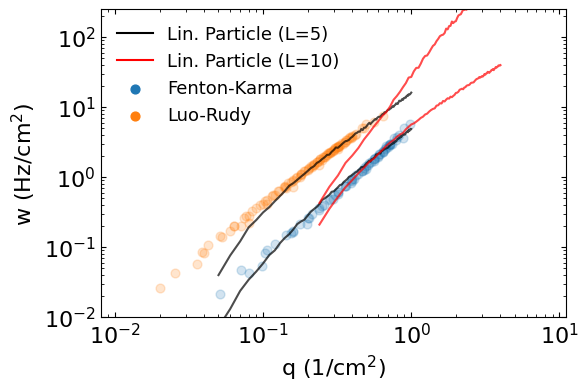

In [40]:
figsize = (6, 4)  #(5,4)
fontsize=16
fig, ax = plt.subplots(figsize=figsize)
ax = plot_death_rates_loglog_full(fk,lr,ax=ax,fontsize=fontsize,x1lim=[0.008, 11], x2lim=[0.01, 250])

# Linear Particle (L=5)
df_fit_fk = dict_results_fk_lst[0]['df_fit']
dg_fit_fk = dict_results_fk_lst[0]['dg_fit']
df_fit_lr = dict_results_lr_lst[0]['df_fit']
dg_fit_lr = dict_results_lr_lst[0]['dg_fit']
df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label=f'Lin. Particle (L=5)')#,label='_Best Fit to FK')
df_fit_lr.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label='_Best Fit to LR')

# Linear Particle (L=10)
df_fit_fk = dict_results_fk_lst[1]['df_fit']
dg_fit_fk = dict_results_fk_lst[1]['dg_fit']
df_fit_lr = dict_results_lr_lst[1]['df_fit']
dg_fit_lr = dict_results_lr_lst[1]['dg_fit']
# df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label=f'Linear Particle (L=10)')#,label='_Best Fit to FK')
df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label=f'Lin. Particle (L=10)')#,label='_Best Fit to FK')
df_fit_lr.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label='_Best Fit to LR')

# format_plot
ax.tick_params(top=True, right=True,direction='in',which='both')
format_plot(ax=ax,xlabel=r'q (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize,use_loglog=True)
# ax.legend(loc='upper left',fontsize=fontsize-2)
# ax.legend(loc='lower right',fontsize=fontsize-2.,frameon=False,ncol=2)
# leg = ax.legend(loc=(1.04,0.2),fontsize=fontsize-2.,frameon=False)
leg = ax.legend(loc='upper left',fontsize=fontsize-3.,frameon=False,ncol=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
# ax.get_legend().remove()

#add annotation
# xytext=(0.09, 10)
# xytext=(0.01, 90)
# ax.annotate(r"best fit ($a>0$)", xy=xy, xytext=xytext,fontsize=fontsize)
# .tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=False,
#                      bottom=False, top=True, left=False, right=False)

xytext=(0.01, 40)
xy=(0.3, 11)
# ax.annotate(r"$a_{max}$ = const.", xy=xy, xytext=(0.01, 40),fontsize=fontsize-2)
# ax.annotate(r"$a_{max}$ fixed to observed", xy=xy, xytext=(0.01, 40),fontsize=fontsize-2)
# ax.annotate(r"$a_{max}$ fixed to observation"+f"\nfrom MSR of full", xy=xy, xytext=(0.01, 40),fontsize=fontsize-2)
# #add marker showing the slope of ~2
# annotation.slope_marker(origin=(.75, 2.0),
#                         slope=2,
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},
#                         ax=ax)
plt.show()

In [41]:
dh_lst=[]
col_lst=['model','amax','L','varkappa','D','r','kappa',
           'rmse','log_likelihood','neighbor',
           'q_lo', 'q_hi','CollTime_lo', 'CollTime_hi','N_lo', 'N_hi',
          'run','cluster_index', 'job_index']

for dict_results_fk in dict_results_fk_lst:
    dg_fit_fk = dict_results_fk['dg_fit']
    dh_lst.append(dg_fit_fk[col_lst])
    #dg_fit_fk = dict_results_fk['dg_fit']
    #dh_lst.append(dg_fit_fk[col_lst])

for dict_results_lr in dict_results_lr_lst:
    dg_fit_lr = dict_results_lr['dg_fit']
    dh_lst.append(dg_fit_lr[col_lst])
    #dg_fit_lr = dict_results_lr['dg_fit']
    #dh_lst.append(dg_fit_lr[col_lst])
df_annihil_fits = pd.concat(dh_lst)
# df_annihil_fits.reset_index(inplace=True)
df_annihil_fits.sort_values(by=['model','rmse'],inplace=True)
df_annihil_fits

,model,amax,L,varkappa,D,r,kappa,rmse,log_likelihood,neighbor,q_lo,q_hi,CollTime_lo,CollTime_hi,N_lo,N_hi,run,cluster_index,job_index
57133,Fenton-Karma,1.780,5.0,1.680,0.050,0.015,960.0,0.077821,18.633107,0.0,0.32,4.0,0.001007,0.076764,8.0,100.0,26,23278799,118
7418,Fenton-Karma,1.780,10.0,1.680,0.050,0.090,250.0,0.228257,87.376207,0.0,0.08,1.0,0.002041,0.290819,8.0,100.0,29,23453634,8055
4551,Luo-Rudy,10.147,10.0,10.047,0.050,0.140,350.0,0.109244,64.951671,0.0,0.08,1.0,0.000621,0.051941,8.0,100.0,29,23453634,7421
71337,Luo-Rudy,3.290,5.0,3.160,0.065,0.200,920.0,1.407300,-217.533320,0.0,0.32,4.0,0.000052,0.037903,8.0,100.0,26,23278799,127676


In [44]:
saving=False
if saving:
    # annihil_fits_dir = f'/home/timothytyree/Documents/GitHub/bgmc/python/data/annihil_fits.{run_num_lst[0]}.{run_num_lst[1]}.csv'
    annihil_fits_dir = f'/home/timothytyree/Documents/GitHub/bgmc/python/data/annihil_fits.'
    # annihil_fits_dir = f'/Users/timothytyree/Documents/GitHub/bgmc/python/data/annihil_fits.'
    for run_num in run_num_lst:
        annihil_fits_dir += f"{run_num}."
    annihil_fits_dir+='csv'
    print(f"{annihil_fits_dir=}")
    #save as .csv and send to WJ right now!
    # annihil_fits_dir = '/home/timothytyree/Documents/GitHub/bgmc/python/data/annihil_fits.csv'
    df_annihil_fits.to_csv(annihil_fits_dir,index=False)
    print(df_annihil_fits)

In [45]:
print(f"Table of maximum likelihood fits of linear particle model to full models.")
print(df_annihil_fits[['model','amax','L','rmse']])

Table of maximum likelihood fits of linear particle model to full models.
              model    amax     L      rmse
57133  Fenton-Karma   1.780   5.0  0.077821
7418   Fenton-Karma   1.780  10.0  0.228257
4551       Luo-Rudy  10.147  10.0  0.109244
71337      Luo-Rudy   3.290   5.0  1.407300


# make table of powerlaw fits

- DONE: make powerlaw fits for particle model
- DONT: plot ^those and verify they look reasonable
- DONE: recall wjr fits
- DONE: stack these values into a pandas data frame
- DONE: print as table, save as powerlaw_fits.csv

In [46]:
wjr=recall_powerlaw_fits_to_full_models()
wjr['fk_pbc']

{'m': 1.8772341309722325,
 'Delta_m': 0.02498750277237229,
 'M': 5.572315674840435,
 'Delta_M': 0.3053120355191732,
 'b': 1.665608066257863,
 'Delta_b': 0.029341409948945123}

In [47]:
dict_fit_lst_full=[]

model_str_fk='Fenton-Karma'
model_str=model_str_fk
print("\n****************************")
print(f"* {model_str}:")
print("****************************")
dict_fit=dict(model=model_str,
              L='-',#np.nan,
              m=wjr['fk_pbc']['m'],
              Delta_m=wjr['fk_pbc']['Delta_m'],
              M=wjr['fk_pbc']['M'],
              Delta_M=wjr['fk_pbc']['Delta_M'],
              B=wjr['fk_pbc']['b'],
              Delta_B=wjr['fk_pbc']['Delta_b']
              )
dict_fit_lst_full.append(dict_fit)
print_dict(dict_fit)

model_str_lr='Luo-Rudy'
model_str=model_str_lr
print("\n****************************")
print(f"* {model_str}:")
print("****************************")
print_dict(wjr['lr_pbc'])
dict_fit=dict(model=model_str,
              L='-',#np.nan,
              m=wjr['lr_pbc']['m'],
              Delta_m=wjr['lr_pbc']['Delta_m'],
              M=wjr['lr_pbc']['M'],
              Delta_M=wjr['lr_pbc']['Delta_M'],
              B=wjr['lr_pbc']['b'],
              Delta_B=wjr['lr_pbc']['Delta_b']
              )
dict_fit_lst_full.append(dict_fit)
# print_dict(dict_fit)
df_fit_full=pd.DataFrame(dict_fit_lst_full)
df_fit_full


****************************
* Fenton-Karma:
****************************
model=Fenton-Karma
L=-
m=1.8772341309722325
Delta_m=0.02498750277237229
M=5.572315674840435
Delta_M=0.3053120355191732
B=1.665608066257863
Delta_B=0.029341409948945123

****************************
* Luo-Rudy:
****************************
m=1.6375562704001745
Delta_m=0.017190912126700632
M=16.73559858353835
Delta_M=0.8465090320196467
b=2.86877101880514
Delta_b=0.0311865277365552


,model,L,m,Delta_m,M,Delta_M,B,Delta_B
0,Fenton-Karma,-,1.877234,0.024988,5.572316,0.305312,1.665608,0.029341
1,Luo-Rudy,-,1.637556,0.017191,16.735599,0.846509,2.868771,0.031187


In [48]:
df_fit_full

,model,L,m,Delta_m,M,Delta_M,B,Delta_B
0,Fenton-Karma,-,1.877234,0.024988,5.572316,0.305312,1.665608,0.029341
1,Luo-Rudy,-,1.637556,0.017191,16.735599,0.846509,2.868771,0.031187


In [49]:
# gener_annihil_powerlaw_fit_ols for particle model
dict_fit_lst=[]

model_str=model_str_fk
print("\n****************************")
print(f"* {model_str}:")
print("****************************")
# Linear Particle (L=5)
df_fit = dict_results_fk_lst[0]['df_fit'].sort_values(by='q')
dict_fit = gener_annihil_powerlaw_fit_ols(df=df_fit,
                                          qmin=0.1,qmax=2)
dict_fit.update(dict(df_fit[['r','kappa','D','varkappa']].drop_duplicates().iloc[0]))
dict_fit['model']=model_str
dict_fit['L']=5
dict_fit_lst.append(dict_fit)

# Linear Particle (L=10)
df_fit = dict_results_fk_lst[1]['df_fit'].sort_values(by='q')
dict_fit = gener_annihil_powerlaw_fit_ols(df=df_fit,
                                          qmin=0.1,qmax=2)
dict_fit.update(dict(df_fit[['r','kappa','D','varkappa']].drop_duplicates().iloc[0]))
dict_fit['model']=model_str
dict_fit['L']=10
dict_fit_lst.append(dict_fit)

model_str=model_str_lr
print("\n****************************")
print(f"* {model_str}:")
print("****************************")
# Linear Particle (L=5)
df_fit = dict_results_lr_lst[0]['df_fit'].sort_values(by='q')
dict_fit = gener_annihil_powerlaw_fit_ols(df=df_fit,
                                          qmin=0.1,qmax=2)
dict_fit.update(dict(df_fit[['r','kappa','D','varkappa']].drop_duplicates().iloc[0]))
dict_fit['model']=model_str
dict_fit['L']=5
dict_fit_lst.append(dict_fit)

# Linear Particle (L=10)
df_fit = dict_results_lr_lst[1]['df_fit'].sort_values(by='q')
dict_fit = gener_annihil_powerlaw_fit_ols(df=df_fit,
                                          qmin=0.1,qmax=2)
dict_fit.update(dict(df_fit[['r','kappa','D','varkappa']].drop_duplicates().iloc[0]))
dict_fit['model']=model_str
dict_fit['L']=10
dict_fit_lst.append(dict_fit)
df_fit_particle = pd.DataFrame(dict_fit_lst)
df_fit_particle


****************************
* Fenton-Karma:
****************************
m = 1.820479 +/- 0.025295
M = 4.857689 +/- 0.211751 Hz/cm^2; B=2.382648 +/- 0.026880
RMSE=0.1505 Hz/cm^2; R^2=0.9955; N=91
m = 1.876806 +/- 0.067095
M = 4.292586 +/- 0.512171 Hz/cm^2; B=2.173329 +/- 0.068859
RMSE=0.9538 Hz/cm^2; R^2=0.9862; N=44

****************************
* Luo-Rudy:
****************************
m = 1.633604 +/- 0.015728
M = 15.813377 +/- 0.609493 Hz/cm^2; B=5.419696 +/- 0.037055
RMSE=0.2598 Hz/cm^2; R^2=0.9979; N=91
m = 2.845852 +/- 0.024763
M = 26.465012 +/- 1.811443 Hz/cm^2; B=3.161628 +/- 0.041797
RMSE=4.3542 Hz/cm^2; R^2=0.9992; N=44


,rmse,Rsq,num_obs,m,Delta_m,M,Delta_M,B,Delta_B,r,kappa,D,varkappa,model,L
0,0.150460,0.995547,91,1.820479,0.025295,4.857689,0.211751,2.382648,0.026880,0.090,250.0,0.050,1.680,Fenton-Karma,5
1,0.953810,0.986220,44,1.876806,0.067095,4.292586,0.512171,2.173329,0.068859,0.015,960.0,0.050,1.680,Fenton-Karma,10
2,0.259790,0.997857,91,1.633604,0.015728,15.813377,0.609493,5.419696,0.037055,0.140,350.0,0.050,10.047,Luo-Rudy,5
3,4.354198,0.999173,44,2.845852,0.024763,26.465012,1.811443,3.161628,0.041797,0.200,920.0,0.065,3.160,Luo-Rudy,10


In [50]:
col_lst=list(df_fit_full.columns)
df_fit=pd.concat((df_fit_particle,df_fit_full))
col_lst=['model', 'L', 'm', 'Delta_m', 'M', 'Delta_M']
print(df_fit)

       rmse       Rsq  num_obs         m   Delta_m          M   Delta_M  \
0  0.150460  0.995547     91.0  1.820479  0.025295   4.857689  0.211751   
1  0.953810  0.986220     44.0  1.876806  0.067095   4.292586  0.512171   
2  0.259790  0.997857     91.0  1.633604  0.015728  15.813377  0.609493   
3  4.354198  0.999173     44.0  2.845852  0.024763  26.465012  1.811443   
0       NaN       NaN      NaN  1.877234  0.024988   5.572316  0.305312   
1       NaN       NaN      NaN  1.637556  0.017191  16.735599  0.846509   

          B   Delta_B      r  kappa      D  varkappa         model   L  
0  2.382648  0.026880  0.090  250.0  0.050     1.680  Fenton-Karma   5  
1  2.173329  0.068859  0.015  960.0  0.050     1.680  Fenton-Karma  10  
2  5.419696  0.037055  0.140  350.0  0.050    10.047      Luo-Rudy   5  
3  3.161628  0.041797  0.200  920.0  0.065     3.160      Luo-Rudy  10  
0  1.665608  0.029341    NaN    NaN    NaN       NaN  Fenton-Karma   -  
1  2.868771  0.031187    NaN    NaN 

In [51]:
#format as pandas table
mindex_lst=['model', 'L']
df_fit['delta'] = np.pi*df_fit['r']**2*df_fit['kappa']
df_fit['a'] = df_fit['varkappa']
df_table_powerlaw=df_fit.sort_values(by=mindex_lst,ascending=False)\
               .set_index(mindex_lst)[['m', 'Delta_m', 'M', 'Delta_M', 'r','kappa', 'delta', 'a', 'D']].T
print(df_table_powerlaw)

model     Luo-Rudy                         Fenton-Karma              \
L                -          10           5            -          10   
m         1.637556    2.845852    1.633604     1.877234    1.876806   
Delta_m   0.017191    0.024763    0.015728     0.024988    0.067095   
M        16.735599   26.465012   15.813377     5.572316    4.292586   
Delta_M   0.846509    1.811443    0.609493     0.305312    0.512171   
r              NaN    0.200000    0.140000          NaN    0.015000   
kappa          NaN  920.000000  350.000000          NaN  960.000000   
delta          NaN  115.610610   21.551326          NaN    0.678584   
a              NaN    3.160000   10.047000          NaN    1.680000   
D              NaN    0.065000    0.050000          NaN    0.050000   

model                
L                 5  
m          1.820479  
Delta_m    0.025295  
M          4.857689  
Delta_M    0.211751  
r          0.090000  
kappa    250.000000  
delta      6.361725  
a          1.680000 

In [52]:
# #TODO(later...): plot the powerlaw fits overlayed on the y-axis
# m=wjr['fk_pbc']['m']
# M=wjr['fk_pbc']['M']
# yhat=M*x**m

In [53]:
#DONE: restart run run but with neighbors=0,1

In [54]:
# #howdo plot lotsa bars 
# f, axarr = plt.subplots(2)

# axarr[0].bar(range(10), range(10))
# axarr[0].tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=False,
#                      bottom=False, top=True, left=False, right=False)

# axarr[1].bar(range(10), range(10, 0, -1))
# axarr[1].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=False,
#                      bottom=True, top=False, left=False, right=False)

# generate minimalist latex tables with formatted dataframes from above

In [55]:
string = format_measurement_string(key='key',val=0,Delta_val=0.123467890,num_digits=6)
print(string)

key = 0.000000 +/- 0.123468


In [56]:
print("\n% df_table_powerlaw")
print(f"% \caption{{Table of powerlaw fits of maximum likelihood fits of pair annihilation rates.}}")
print(df_table_powerlaw)

print("\n% df_table_mle")
print(f"% \caption{{Table of maximum likelihood fits of pair annihilation rates to the full models (complete table in Supplementary).}}")
df_table_mle=df_annihil_fits.sort_values(by=mindex_lst,ascending=False)\
               .set_index(mindex_lst)[['amax','rmse']].T
print(df_table_mle)


print("\n% df_table_mle_complete")
print(f"% \caption{{Table of maximum likelihood fits of pair annihilation rates to the full models.}}")
df_table_mle_complete=df_annihil_fits.sort_values(by=mindex_lst,ascending=False)\
               .set_index(mindex_lst).T #[['m', 'Delta_m', 'M', 'Delta_M']].T
print(df_table_mle_complete)




% df_table_powerlaw
% \caption{Table of powerlaw fits of maximum likelihood fits of pair annihilation rates.}
model     Luo-Rudy                         Fenton-Karma              \
L                -          10           5            -          10   
m         1.637556    2.845852    1.633604     1.877234    1.876806   
Delta_m   0.017191    0.024763    0.015728     0.024988    0.067095   
M        16.735599   26.465012   15.813377     5.572316    4.292586   
Delta_M   0.846509    1.811443    0.609493     0.305312    0.512171   
r              NaN    0.200000    0.140000          NaN    0.015000   
kappa          NaN  920.000000  350.000000          NaN  960.000000   
delta          NaN  115.610610   21.551326          NaN    0.678584   
a              NaN    3.160000   10.047000          NaN    1.680000   
D              NaN    0.065000    0.050000          NaN    0.050000   

model                
L                 5  
m          1.820479  
Delta_m    0.025295  
M          4.857689

In [57]:
##############################
# LaTeX table generation
##############################
print("% ****************************")
print("% * Generated LaTeX tables")
print("% **************************")
kwargs_table_2_levels=dict(float_format="{:0.4f}".format,
                          multicolumn_format='c',
#                            column_format='c',
#                            caption=('Table. ?? shows full\_caption', 'Table. ?? short\_caption.'),
#                            longtable=True #Requires adding a usepackage{longtable} to your LaTeX preamble.
                          )
print("% df_table_powerlaw")
print("% \begin{ruledtabular}")
print("% \begin{tabular}{cccccc}")
print(df_table_powerlaw.reset_index().to_latex(index=False, 
                                               caption='shows powerlaw fits  to the mean pair-annihilation rates for the full models and for the linear particle models at a relatively short length scale ($L=5$ cm) and at a relatively long length scale ($L=10$ cm).  Parameter settings for the linear particle model correspond to Tab. \ref{tab:df_table_mle_complete}}\label{tab:df_table_powerlaw})',
                                               **kwargs_table_2_levels))
# print(f"% \caption{{Table of powerlaw fits of maximum likelihood fits of pair annihilation rates.}}\label{{tab:df_table_powerlaw}})")

print("\n% df_table_mle")
print("% \begin{ruledtabular}")
print("% \begin{tabular}{cccccc}")
print(df_table_mle.reset_index().to_latex(index=False, 
                                          caption='Table of maximum likelihood fits of pair annihilation rates to the full models (complete table in Supplementary).}\label{tab:df_table_mle}',
                                          **kwargs_table_2_levels))
# print(f"% \caption{{Table of maximum likelihood fits of pair annihilation rates to the full models (complete table in Supplementary).}}\label{{tab:df_table_mle}}")

print("\n% df_table_mle_complete")
print("% \begin{ruledtabular}")
print("% \begin{tabular}{cccccc}")
print(df_table_mle_complete.reset_index().to_latex(index=False, 
                                                   caption='shows maximum likelihood fits of the mean pair-annihilation rates of the linear particle model to those of the full models. Results are shown for the linear particle model at a relatively short length scale ($L=5$ cm) and at a relatively long length scale ($L=10$ cm).}\label{tab:df_table_mle_complete}',
                                                   **kwargs_table_2_levels))
# print(f"% \caption{{Table of maximum likelihood fits of pair annihilation rates to the full models.}}\label{{tab:df_table_mle_complete}}")

% ****************************
% * Generated LaTeX tables
% **************************
% df_table_powerlaw
% egin{ruledtabular}
% egin{tabular}{cccccc}
\begin{table}
\centering
ef{tab:df_table_mle_complete}}\label{tab:df_table_powerlaw})}
\begin{tabular}{lrrrrrr}
\toprule
  index & \multicolumn{3}{c}{Luo-Rudy} & \multicolumn{3}{c}{Fenton-Karma} \\
        &        - &       10 &        5 &            - &       10 &        5 \\
\midrule
      m &   1.6376 &   2.8459 &   1.6336 &       1.8772 &   1.8768 &   1.8205 \\
Delta\_m &   0.0172 &   0.0248 &   0.0157 &       0.0250 &   0.0671 &   0.0253 \\
      M &  16.7356 &  26.4650 &  15.8134 &       5.5723 &   4.2926 &   4.8577 \\
Delta\_M &   0.8465 &   1.8114 &   0.6095 &       0.3053 &   0.5122 &   0.2118 \\
      r &      NaN &   0.2000 &   0.1400 &          NaN &   0.0150 &   0.0900 \\
  kappa &      NaN & 920.0000 & 350.0000 &          NaN & 960.0000 & 250.0000 \\
  delta &      NaN & 115.6106 &  21.5513 &          NaN &   0.6786 &  

In [58]:
# df_table_mle_complete.to_latex?

In [59]:
#DONE: dev foo that maps a .csv to a latex table
#HINT: search stackoverflow
#TODO: make mle parameter table into latex table
#HINT: query the dataframe and then search stackoverflow
#DONT: wrap in modules of foo. just use pandas.DataFrame.to_latex? in the future

# DONE: plot the fits for increasing/decreasing D at the shorter length scale
TODO: answer Q: 
- Q: does it make sense to plot other variables versus D?

In [60]:
# df_fit = dict_results_fk_lst[0]['df_fit'].sort_values(by='q')
# dict_fit = gener_annihil_powerlaw_fit_ols(df=df_fit,
#                                           qmin=0.1,qmax=2)

In [61]:
#option 1:
#TODO: look for a summary dataframe and use it to query my filesystem
#option 2:
#TODO: copy where I generate dict_results_fk_lst[0]

In [64]:
# latest_run_num=27
run_num_lst = list(reversed(list(np.arange(14,latest_run_num+1))))
# run_num_lst=[25,17]
# run_num_lst=[25,19]
# run_num_lst=[25,24]
# run_num_lst=[25,18]
# run_num_lst=[25,27]
# run_num_lst=[25,28]
# run_num_lst=[28,25]
run_num_lst=[25,26]
# run_num_lst=[26]
# run_num=25 #L=5 cm, neighbors=1
# run_num=18 #L=10 cm, neighbors=0
remove_no_diffusion=True
# Dinf=0
Dinf=0.01
num_digits_round_amax=3

gmin_fk_lst=[]
gmin_lr_lst=[]
log_dir_fk_lst=[]
log_dir_lr_lst=[]
dict_results_fk_lst=[]
dict_results_lr_lst=[]
# for run_num in [25,18]: #chosen exemplar pair
for run_num in run_num_lst:
    parquet_dir_defects_fk=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_fk.parquet'
    parquet_dir_defects_lr=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_lr.parquet'
    input_folder=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'
    #load data
    df_defects_fk=pd.read_parquet(parquet_dir_defects_fk)
    df_defects_lr=pd.read_parquet(parquet_dir_defects_lr)
    #compute order parameter for each member a=amax-2*D
    #add columns for amax
    df_defects_fk['amax'] = np.around(df_defects_fk['varkappa'] + 2.*df_defects_fk['D'],num_digits_round_amax)
    df_defects_lr['amax'] = np.around(df_defects_lr['varkappa'] + 2.*df_defects_lr['D'],num_digits_round_amax)
    
    if remove_no_diffusion:
        df_defects_fk = df_defects_fk[df_defects_fk['D']>Dinf].copy()
        df_defects_lr = df_defects_lr[df_defects_lr['D']>Dinf].copy()
    
    #identify the lowest error simulation for each amax value
    print(f"\n**************************************")
    print(f"* Fenton-Karma Model (best settings):")
    print(f"**************************************")
    minrmse=9999.
    supamax=1.8
    #supamax=40.
    print_str=None
    for amax,g in df_defects_fk.groupby(by='amax'):
        rmse_min = g['rmse'].min()
        count = g['rmse'].count()
        log_likelihood = g['log_likelihood'].max()
        if (rmse_min<=minrmse)&(amax<=supamax):
            minrmse=rmse_min
            gmin_fk=g.copy()
            print_str =f"{amax=:.4f}, {rmse_min=:.4f}, {log_likelihood=:.4f}, {count=}"
    if print_str is not None:
        print(print_str)#print(print_str)
    gmin_fk.sort_values(by='D',inplace=True)
    

    #find best simulation for the full model at this avalue
#     dg_fk=gmin_fk[gmin_fk['rmse'] == gmin_fk['rmse'].min()].copy()
    dg_fk=gmin_fk[gmin_fk['log_likelihood'] == gmin_fk['log_likelihood'].max()].copy()
    dg_fk['run']=run_num
    df_defects_fk['run']=run_num
    dg_fk['model']='Fenton-Karma'
    cluster_index,job_index = dg_fk[['cluster_index','job_index']].values.T
    input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
    #assert os.path.exists(input_fn)
    if os.path.exists(input_fn):
        input_fn_fk=input_fn
        df_fit_fk,dict_linear_fit_fk = routine_measure_annihilation_defect(input_fn,printing=True)#,**kwargs)
        amax_fk=dg_fk['amax'].median()
        rmse_fk=dg_fk['rmse'].median()
        L = dg_fk['L'].median()
        print(f"\nbest fit for Fenton-Karma: RMSE: {rmse_fk:.4f} Hz/cm^2, amax: {amax_fk:.4f} cm^2/s, L: {L} cm")
        print(f"{input_fn_fk=}")
        #record
        dict_results_fk=dict(
            model_name='Fenton-Karma',
            amax=amax_fk,
            rmse=rmse_fk,
            L=L,
            df_fit=df_fit_fk,
            dg_fit=dg_fk,
            dict_linear_fit=dict_linear_fit_fk,
            filename=input_fn_fk,
            gmin=gmin_fk)
        dict_results_fk_lst.append(dict_results_fk)
        gmin_fk_lst.append(gmin_fk)
        log_dir_fk_lst.append(input_fn)
    
    #identify the lowest error simulation for each amax value
    print(f"\n**************************************")
    print(f"* Luo-Rudy Model (best settings):")
    print(f"**************************************")
    minrmse=9999.
    supamax=10.2
    print_str=None
    for amax,g in df_defects_lr.groupby(by='amax'):
        rmse_min = g['rmse'].min()
        count = g['rmse'].count()
        log_likelihood = g['log_likelihood'].max()
        if (rmse_min<=minrmse)&(amax<=supamax):
            minrmse=rmse_min
            gmin_lr=g.copy()
            print_str =f"{amax=:.4f}, {rmse_min=:.4f}, {log_likelihood=:.4f}, {count=}"
    if print_str is not None:
        print(print_str)#print(print_str)        
    gmin_lr.sort_values(by='D',inplace=True)
    
    #find best simulation for the full model at this avalue
#     dg_lr=gmin_lr[gmin_lr['rmse'] == gmin_lr['rmse'].min()].copy()
    dg_lr=gmin_lr[gmin_lr['log_likelihood'] == gmin_lr['log_likelihood'].max()].copy()
    dg_lr['run']=run_num
    df_defects_lr['run']=run_num
    dg_lr['model']='Luo-Rudy'
    cluster_index,job_index = dg_lr[['cluster_index','job_index']].values.T
    input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
    #assert os.path.exists(input_fn)
    if os.path.exists(input_fn):
        input_fn_lr=input_fn
        df_fit_lr,dict_linear_fit_lr = routine_measure_annihilation_defect(input_fn,printing=True)#,**kwargs)
        amax_lr=dg_fk['amax'].median()
        rmse_lr=dg_lr['rmse'].median()
        L = dg_lr['L'].median()
        print(f"\nbest fit for Luo-Rudy: RMSE: {rmse_lr:.4f} Hz/cm^2, amax: {amax_lr:.4f} cm^2/s, L: {L} cm")
        print(f"{input_fn_lr=}")
        #record
        dict_results_lr=dict(
            model_name='Luo-Rudy',
            amax=amax_lr,
            rmse=rmse_lr,
            L=L,
            df_fit=df_fit_lr,
            dg_fit=dg_lr,
            dict_linear_fit=dict_linear_fit_lr,
            filename=input_fn_lr,
            gmin=gmin_lr)
        dict_results_lr_lst.append(dict_results_lr)
        gmin_lr_lst.append(gmin_lr)
        log_dir_lr_lst.append(input_fn)

    print(f"\nparameter range supported in run #{run_num}:")
    print(f"number of trials: {df_defects_lr.shape[0]}")
    print(df_defects_lr.describe()[['r','kappa','D','varkappa','amax','L','neighbor']].T[['min','max']].T)




FileNotFoundError: [Errno 2] No such file or directory: '/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_25_defects_to_fk.parquet'

In [289]:
df_defects_fk.head()

,num_obs,qmin,qmax,rmse,log_likelihood,emin,emax,lemin,lemax,no_repulsion,...,N_lo,N_hi,w_lo,w_hi,CollTime_lo,CollTime_hi,cluster_index,job_index,amax,run
0,17,0.32,0.96,1.536218,-429.017446,0.126243,2.469428,0.126243,2.469428,0.0,...,8.0,100.0,0.782519,80.000000,0.000500,0.051117,23278799,50567,2.89,26
1,17,0.32,0.96,0.435451,-57.585285,-0.223722,0.998285,-0.223722,0.998285,0.0,...,8.0,100.0,0.432554,105.540897,0.000379,0.092474,23278799,91787,2.89,26
2,17,0.32,0.96,0.665275,-716.531786,-0.430232,1.643788,-0.430232,1.643788,0.0,...,8.0,100.0,0.226044,314.960630,0.000127,0.176957,23278799,36347,1.78,26
3,17,0.32,0.96,5.293042,-2123.103438,0.224529,10.961284,0.224529,10.961284,0.0,...,8.0,100.0,0.880805,388.349515,0.000103,0.045413,23278799,48932,2.89,26
4,17,0.32,0.96,0.798013,-142.705099,-0.089085,-1.780585,-0.089085,-1.780585,0.0,...,8.0,100.0,0.567191,20.597322,0.001942,0.070523,23278799,150744,3.29,26


In [290]:
df_defects_fk.head()

,num_obs,qmin,qmax,rmse,log_likelihood,emin,emax,lemin,lemax,no_repulsion,...,N_lo,N_hi,w_lo,w_hi,CollTime_lo,CollTime_hi,cluster_index,job_index,amax,run
0,17,0.32,0.96,1.536218,-429.017446,0.126243,2.469428,0.126243,2.469428,0.0,...,8.0,100.0,0.782519,80.000000,0.000500,0.051117,23278799,50567,2.89,26
1,17,0.32,0.96,0.435451,-57.585285,-0.223722,0.998285,-0.223722,0.998285,0.0,...,8.0,100.0,0.432554,105.540897,0.000379,0.092474,23278799,91787,2.89,26
2,17,0.32,0.96,0.665275,-716.531786,-0.430232,1.643788,-0.430232,1.643788,0.0,...,8.0,100.0,0.226044,314.960630,0.000127,0.176957,23278799,36347,1.78,26
3,17,0.32,0.96,5.293042,-2123.103438,0.224529,10.961284,0.224529,10.961284,0.0,...,8.0,100.0,0.880805,388.349515,0.000103,0.045413,23278799,48932,2.89,26
4,17,0.32,0.96,0.798013,-142.705099,-0.089085,-1.780585,-0.089085,-1.780585,0.0,...,8.0,100.0,0.567191,20.597322,0.001942,0.070523,23278799,150744,3.29,26


In [291]:
run_num,cluster_index,job_index

(26, array([23278799]), array([127676]))

In [292]:
annihil_log_dir = recall_annihil_log_dir(run_num,cluster_index,job_index)
assert os.path.exists(annihil_log_dir)
df=pd.read_csv(annihil_log_dir)
df['q'] = df['N']/(df['L']**2)
df['w'] = (df['CollTime']**-1)/(df['L']**2)
# .sort_values(by='q')
# df['q']

In [293]:
df_defects_fk['amax'].drop_duplicates().values

array([2.89, 1.78, 3.29])

In [294]:
# amax = 10.147 #LR 200x200 diffCoeff=0.001, src: wj
# df_defects = df_defects_lr[df_defects_lr['amax']==amax].sort_values(by='D')

amax=1.78 #FK 200x200 diffCoeff=0.0005, src: wj
# amax=1.781 #FK 200x200 diffCoeff=0.0005, src: wj
df_defects = df_defects_fk[df_defects_fk['amax']==amax].sort_values(by='D')
print(f"range of parameter settings:")
print(df_defects.describe()[['r','kappa','D','varkappa','amax','L']].T[['min','max','count']].T)
df_defects.head()

range of parameter settings:
               r    kappa         D  varkappa      amax        L
min        0.005    200.0      0.05      0.30      1.78      5.0
max        0.200    980.0      0.74      1.68      1.78      5.0
count  44475.000  44475.0  44475.00  44475.00  44475.00  44475.0


,num_obs,qmin,qmax,rmse,log_likelihood,emin,emax,lemin,lemax,no_repulsion,...,N_lo,N_hi,w_lo,w_hi,CollTime_lo,CollTime_hi,cluster_index,job_index,amax,run
112845,17,0.32,0.96,0.098287,9.030665,-0.166206,-0.113929,-0.166206,-0.113929,0.0,...,8.0,100.0,0.490070,40.444894,0.000989,0.081621,23278799,116,1.78,26
143707,17,0.32,0.96,0.849868,-90.117489,-0.128272,1.648422,-0.128272,1.648422,0.0,...,8.0,100.0,0.528004,93.240093,0.000429,0.075757,23278799,439,1.78,26
159257,17,0.32,0.96,0.237745,-2.091206,-0.143357,-0.544442,-0.143357,-0.544442,0.0,...,8.0,100.0,0.512919,34.965035,0.001144,0.077985,23278799,173,1.78,26
42236,17,0.32,0.96,0.370223,-5.932909,-0.135280,0.656935,-0.135280,0.656935,0.0,...,8.0,100.0,0.520996,77.220077,0.000518,0.076776,23278799,725,1.78,26
143703,17,0.32,0.96,0.125002,8.998683,-0.150874,0.259541,-0.150874,0.259541,0.0,...,8.0,100.0,0.505401,46.620047,0.000858,0.079145,23278799,331,1.78,26


In [295]:
D_values = np.sort(df_defects['D'].drop_duplicates().values)
#for each D value
q_values_lst=[]
w_values_lst=[]
dg_fit_lst=[]
for D in D_values:
    #find the maximum likelihood parameter setting row
    dg=df_defects[df_defects['D']==D]
    dg_fit=dg[dg['log_likelihood']==dg['log_likelihood'].max()].copy()
    print(dg_fit[['amax','L', 'r', 'kappa',
                    'D', 'varkappa', 'neighbor',
    #     'q_lo', 'q_hi', 'w_lo', 'w_hi',
#         'run','cluster_index', 
                  'job_index'
                 ]])

    #load xy values with recall_annihilation_log
    annihil_log_dir = recall_annihil_log_dir(run_num=dg_fit['run'].values[0],
                                             cluster_index=dg_fit['cluster_index'].values[0],
                                             job_index=dg_fit['job_index'].values[0])
    assert os.path.exists(annihil_log_dir)
    df,dict_linear = recall_annihilation_log(annihil_log_dir,printing=True)#,**kwargs)
    q_values,w_values = df.sort_values(by='q')[['q','w']].values.T

    #record the xy values with the D values
    q_values_lst.append(q_values)
    w_values_lst.append(w_values)
    dict_linear['D']=D
    dg_fit_lst.append(dg_fit)

       amax    L      r  kappa     D  varkappa  neighbor  job_index
57133  1.78  5.0  0.015  960.0  0.05      1.68       0.0        118
amax: 1.7800 cm^2/s, L: 5.0 cm, RMSE as fit to annihilation rates from full: 0.0778 Hz/cm^2
input_fn_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_all/job.out.23278799.118'
        amax    L      r  kappa      D  varkappa  neighbor  job_index
133355  1.78  5.0  0.025  620.0  0.065      1.65       0.0       1141
amax: 1.7800 cm^2/s, L: 5.0 cm, RMSE as fit to annihilation rates from full: 0.0778 Hz/cm^2
input_fn_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_all/job.out.23278799.118'
       amax    L      r  kappa     D  varkappa  neighbor  job_index
39097  1.78  5.0  0.015  880.0  0.08      1.62       0.0       2034
amax: 1.7800 cm^2/s, L: 5.0 cm, RMSE as fit to annihilation rates from full: 0.0778 Hz/cm^2
input_fn_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_all/job.

amax: 1.7800 cm^2/s, L: 5.0 cm, RMSE as fit to annihilation rates from full: 0.0778 Hz/cm^2
input_fn_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_all/job.out.23278799.118'
        amax    L     r  kappa      D  varkappa  neighbor  job_index
124659  1.78  5.0  0.18  260.0  0.455      0.87       0.0      26803
amax: 1.7800 cm^2/s, L: 5.0 cm, RMSE as fit to annihilation rates from full: 0.0778 Hz/cm^2
input_fn_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_all/job.out.23278799.118'
        amax    L    r  kappa     D  varkappa  neighbor  job_index
146536  1.78  5.0  0.2  200.0  0.47      0.84       0.0      27800
amax: 1.7800 cm^2/s, L: 5.0 cm, RMSE as fit to annihilation rates from full: 0.0778 Hz/cm^2
input_fn_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_26_all/job.out.23278799.118'
       amax    L    r  kappa      D  varkappa  neighbor  job_index
10056  1.78  5.0  0.2  200.0  0.485      0.81       0.0

In [296]:
dg_fit_lst[0]

,num_obs,qmin,qmax,rmse,log_likelihood,emin,emax,lemin,lemax,no_repulsion,...,N_lo,N_hi,w_lo,w_hi,CollTime_lo,CollTime_hi,cluster_index,job_index,amax,run
57133,17,0.32,0.96,0.077821,18.633107,-0.135198,0.068878,-0.135198,0.068878,0.0,...,8.0,100.0,0.521078,39.721946,0.001007,0.076764,23278799,118,1.78,26


In [297]:
dd=pd.concat(dg_fit_lst)
dd['delta']=np.pi*dd['kappa']*dd['r']**2/dd['L']**2
dd['krod']=np.pi*dd['kappa']*dd['r']**2/dd['D']
dd['kroa']=np.pi*dd['kappa']*dd['r']**2/dd['varkappa']
dd['doa']=dd['D']/dd['varkappa']
dd['likelihood']=np.exp(dd['log_likelihood'])

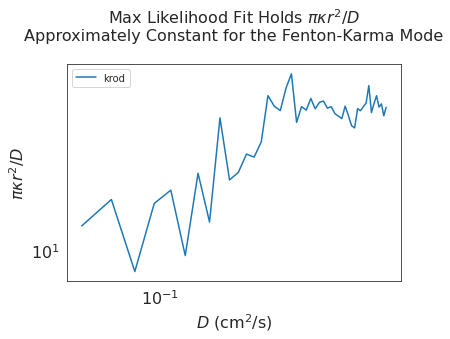

In [298]:
figsize = (6, 4)  #(5,4)
fontsize=16
fig, ax = plt.subplots(figsize=figsize)
# dd.plot(x='D',y=['delta','rmse'],ax=ax)  
# dd.plot(x='D',y=['kappa'],ax=ax)  
dd.plot(x='D',y=['krod'],ax=ax)  
format_plot(ax=ax,xlabel=r'$D$ (cm$^2$/s)',ylabel=r'$\pi \kappa r^2/D$',fontsize=fontsize,use_loglog=True)
ax.set_title('Max Likelihood Fit Holds '+r'$\pi \kappa r^2/D$'+'\nApproximately Constant for the Fenton-Karma Mode\n',fontsize=fontsize)
plt.show()

True

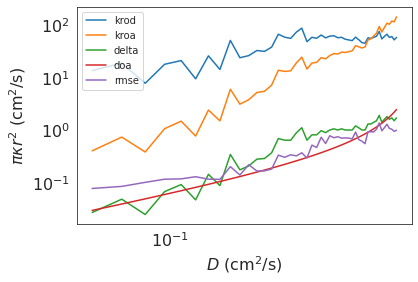

In [299]:
# col_lst=['D', 'varkappa','delta','rmse','log_likelihood','r', 'kappa']
# sns.pairplot(dd[col_lst])

figsize = (6, 4)  #(5,4)
fontsize=16
fig, ax = plt.subplots(figsize=figsize)
# col_lst=['varkappa','delta','rmse','log_likelihood']
# col_lst=['varkappa','delta','rmse','likelihood']
# col_lst=['varkappa','delta','rmse']
col_lst=['krod','kroa','delta','doa','rmse']
# col_lst=['varkappa','delta']

# for col in col_lst:
dd.plot(x='D',y=col_lst,ax=ax)  
format_plot(ax=ax,xlabel='$D$ (cm$^2$/s)',ylabel='$\pi \kappa r^2$ (cm$^2$/s)',fontsize=fontsize,use_loglog=True)   

True

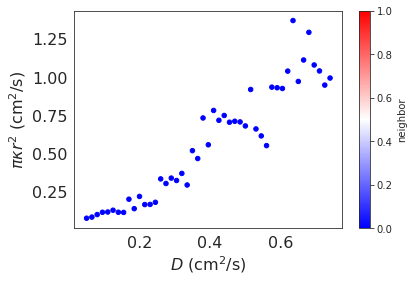

In [300]:
# col_lst=['D', 'varkappa','delta','rmse','log_likelihood','r', 'kappa']
# sns.pairplot(dd[col_lst])

figsize = (6, 4)  #(5,4)
fontsize=16
fig, ax = plt.subplots(figsize=figsize)
# col_lst=[,'rmse','log_likelihood']
# for col in col_lst:
# dd.plot.scatter(x='D',y='rmse',ax=ax)
dd.plot.scatter(x='D',y='rmse',ax=ax,c='neighbor',cmap='bwr',vmin=0,vmax=1)
# dd.plot.scatter(x='D',y='rmse',c='neighbor',cmap='bwr',vmin=0,vmax=1,ax=ax)
format_plot(ax=ax,xlabel='$D$ (cm$^2$/s)',ylabel='$\pi \kappa r^2$ (cm$^2$/s)',fontsize=fontsize,use_loglog=False)   

True

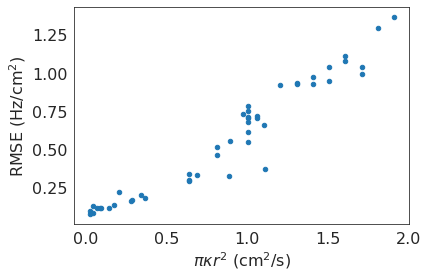

In [301]:
figsize = (6, 4)  #(5,4)
fontsize=16
fig, ax = plt.subplots(figsize=figsize)
# col_lst=[,'rmse','log_likelihood']
# for col in col_lst:
dd.plot.scatter(x='delta',y='rmse',ax=ax)
# dd.plot.scatter(x='D',y='rmse',c='neighbor',cmap='bwr',vmin=0,vmax=1,ax=ax)
format_plot(ax=ax,xlabel='$\pi \kappa r^2$ (cm$^2$/s)',ylabel='RMSE (Hz/cm$^2$)',fontsize=fontsize,use_loglog=False)   

True

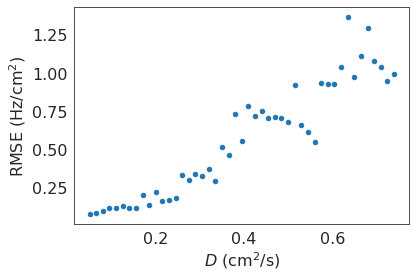

In [302]:
figsize = (6, 4)  #(5,4)
fontsize=16
fig, ax = plt.subplots(figsize=figsize)
# col_lst=[,'rmse','log_likelihood']
# for col in col_lst:
dd.plot.scatter(x='D',y='rmse',ax=ax)
# dd.plot.scatter(x='D',y='rmse',c='neighbor',cmap='bwr',vmin=0,vmax=1,ax=ax)
format_plot(ax=ax,xlabel='$D$ (cm$^2$/s)',ylabel='RMSE (Hz/cm$^2$)',fontsize=fontsize,use_loglog=False)   

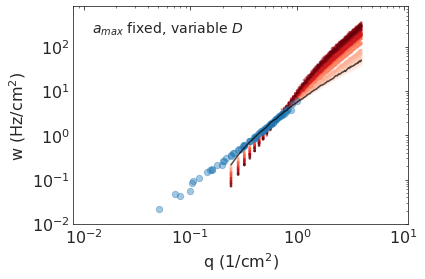

In [303]:
figsize = (6, 4)  #(5,4)
fontsize=16
fig, ax = plt.subplots(figsize=figsize)
#overlay with original death rates from wj
ax = plot_death_rates_loglog_full(fk,lr,ax=ax,fontsize=fontsize,
                                  x1lim=[0.008, 11], 
                                  x2lim=[0.01, 800],#250],
                                  show_fk=True, show_lr=False,alpha=.4
                                 )

#plot the mle fits / loci of constant amax for increasing D
vmin=np.min(D_values)
vmax=np.max(D_values)
#for each D value
for D,x,y in zip(D_values,q_values_lst,w_values_lst):
    #plot the xy values for the mle fit
    ax.scatter(x,y,c=D+0.*x,cmap='Reds',vmin=vmin,vmax=vmax,label=f'{D=}',s=3,alpha=0.4,zorder=-1)

    
# Linear Particle (L=5)
df_fit_fk = dict_results_fk_lst[0]['df_fit']
dg_fit_fk = dict_results_fk_lst[0]['dg_fit']
df_fit_lr = dict_results_lr_lst[0]['df_fit']
dg_fit_lr = dict_results_lr_lst[0]['dg_fit']
df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label=f'Lin. Particle (L=5)')#,label='_Best Fit to FK')
# df_fit_lr.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label='_Best Fit to LR')

# # Linear Particle (L=10)
# df_fit_fk = dict_results_fk_lst[1]['df_fit']
# dg_fit_fk = dict_results_fk_lst[1]['dg_fit']
# df_fit_lr = dict_results_lr_lst[1]['df_fit']
# dg_fit_lr = dict_results_lr_lst[1]['dg_fit']
# # df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label=f'Linear Particle (L=10)')#,label='_Best Fit to FK')
# df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label=f'Lin. Particle (L=10)')#,label='_Best Fit to FK')
# # df_fit_lr.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label='_Best Fit to LR')


# format_plot
ax.tick_params(top=True, right=True,direction='in',which='both')
format_plot(ax=ax,xlabel=r'q (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize,use_loglog=True)
# ax.legend(loc='upper left',fontsize=fontsize-2)
# ax.legend(loc='lower right',fontsize=fontsize-2.,frameon=False,ncol=2)
# leg = ax.legend(loc=(1.04,0.2),fontsize=fontsize-7.,frameon=False)
# # leg = ax.legend(loc='upper left',fontsize=fontsize-3.,frameon=False,ncol=1)
# for lh in leg.legendHandles: 
#     lh.set_alpha(1)
ax.get_legend().remove()

#add annotation
# xytext=(0.09, 10)
# xytext=(0.01, 90)
# ax.annotate(r"best fit ($a>0$)", xy=xy, xytext=xytext,fontsize=fontsize)
# .tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=False,
#                      bottom=False, top=True, left=False, right=False)


ax.annotate(r"$a_{max}$ fixed, variable $D$", xy=(0.3, 11), xytext=(0.012, 200),fontsize=fontsize-2)
# xytext=(0.01, 240)
# xy=(0.3, 11)
# ax.annotate(r"$a_{max}$ = const.", xy=xy, xytext=(0.01, 40),fontsize=fontsize-2)
# ax.annotate(r"$a_{max}$ fixed to observed", xy=xy, xytext=(0.01, 40),fontsize=fontsize-2)
# ax.annotate(r"$a_{max}$ fixed to observation"+f"\nfrom MSR of full", xy=xy, xytext=(0.01, 40),fontsize=fontsize-2)
show_annoatations=False
if show_annoatations:
    # #add marker showing slope
    annotation.slope_marker(origin=(1.8, 10),
                            slope=1.4,
                            text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
                            poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},ax=ax)
    annotation.slope_marker(origin=(.75, 2.0),
                            slope=2,
                            text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
                            poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},ax=ax)
    annotation.slope_marker(origin=(.35, .20),
                            slope=3,
                            text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
                            poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},ax=ax)
plt.show()

# TODO: streamplot of log likelihood in ($r$,$\kappa$) to show attraction along line of constant $\kappa\pi r^2$

In [35]:
#DONEE: write rmse from full powerlaw fit in notebook
#DONE: recompute df_defects using the correct s (rmse from full powerlaw fit) in the likelihood computation
#TODO: reload df_defects in the above from run_num=26
#TODO: copy/paste the best parameter setting using the apparent maximum of likelihood
#TODO: select all r,kappa that with a,D,neighbor,L fixed explicitely by ^that
#TODO: scatter plot r,kappa on an xy scatter plot, coloring by log likelihood
#TODO: 
run_num=26
num_digits_round_amax=3
L=5

In [36]:
# input_folder=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'
parquet_dir_defects_fk=f'/Users/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_fk.parquet'
# parquet_dir_defects_lr=f'/Users/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_lr.parquet'
# parquet_dir_defects_lr=f'/Users/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_lr.parquet'
input_folder=f'/Users/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'


#load data
parquet_dir_defects_fk=f'{nb_dir}/data/osg_output/run_{run_num}_defects_to_fk.parquet'
parquet_dir_defects_lr=f'{nb_dir}/data/osg_output/run_{run_num}_defects_to_lr.parquet'

df_defects_fk=pd.read_parquet(parquet_dir_defects_fk)
df_defects_lr=pd.read_parquet(parquet_dir_defects_lr)

#add columns for amax
df_defects_fk['amax'] = np.around(df_defects_fk['varkappa'] + 2.*df_defects_fk['D'],num_digits_round_amax)
df_defects_lr['amax'] = np.around(df_defects_lr['varkappa'] + 2.*df_defects_lr['D'],num_digits_round_amax)
L_fk = df_defects_fk['L'].values[0]
L_lr = df_defects_lr['L'].values[0]
print(f"{L_fk=}, {L_lr=}")




L_fk=5.0, L_lr=5.0


In [37]:
# amax = 10.147 #LR 200x200 diffCoeff=0.001, src: wj
# df_defects = df_defects_lr[df_defects_lr['amax']==amax].sort_values(by='D')

amax=1.78 #FK 200x200 diffCoeff=0.0005, src: wj
# amax=1.781 #FK 200x200 diffCoeff=0.0005, src: wj
df_defects = df_defects_fk[df_defects_fk['amax']==amax].sort_values(by='D')
print(f"range of parameter settings: ({df_defects.shape=})")
print(df_defects.describe()[['r','kappa','D','varkappa','amax','L']].T[['min','max','count']].T)
df_defects.head()

range of parameter settings: (df_defects.shape=(44475, 35))
               r    kappa         D  varkappa      amax        L
min        0.005    200.0      0.05      0.30      1.78      5.0
max        0.200    980.0      0.74      1.68      1.78      5.0
count  44475.000  44475.0  44475.00  44475.00  44475.00  44475.0


,num_obs,qmin,qmax,rmse,log_likelihood,emin,emax,lemin,lemax,no_repulsion,...,q_hi,N_lo,N_hi,w_lo,w_hi,CollTime_lo,CollTime_hi,cluster_index,job_index,amax
112845,17,0.32,0.96,0.098287,9.030665,-0.166206,-0.113929,-0.166206,-0.113929,0.0,...,4.0,8.0,100.0,0.490070,40.444894,0.000989,0.081621,23278799,116,1.78
143707,17,0.32,0.96,0.849868,-90.117489,-0.128272,1.648422,-0.128272,1.648422,0.0,...,4.0,8.0,100.0,0.528004,93.240093,0.000429,0.075757,23278799,439,1.78
159257,17,0.32,0.96,0.237745,-2.091206,-0.143357,-0.544442,-0.143357,-0.544442,0.0,...,4.0,8.0,100.0,0.512919,34.965035,0.001144,0.077985,23278799,173,1.78
42236,17,0.32,0.96,0.370223,-5.932909,-0.135280,0.656935,-0.135280,0.656935,0.0,...,4.0,8.0,100.0,0.520996,77.220077,0.000518,0.076776,23278799,725,1.78
143703,17,0.32,0.96,0.125002,8.998683,-0.150874,0.259541,-0.150874,0.259541,0.0,...,4.0,8.0,100.0,0.505401,46.620047,0.000858,0.079145,23278799,331,1.78


In [38]:
# df_defects.groupby(by='varkappa')['varkappa'].count()
# .hist()
# plt.show()

In [39]:
#identify the best parameter setting
max_likelihood = df_defects['log_likelihood'].max()
dg = df_defects[max_likelihood == df_defects['log_likelihood']]
alinear_best = dg['varkappa'].values[0]
D_best = dg['D'].values[0]
r_best = dg['r'].values[0]
kappa_best = dg['kappa'].values[0]
L_best = dg['L'].values[0]
neighbor_best = dg['neighbor'].values[0]
print((alinear_best,D_best,neighbor_best,L_best))
print((r_best,kappa_best))
np.min(df_defects['log_likelihood']),max_likelihood

(1.68, 0.05, 0.0, 5.0)
(0.015, 960.0)


(-24055.81568028658, 18.63310679757182)

In [40]:
# (1.68, 0.05, 0.0, 5.0)
# (0.03, 720.0)
df_defects['x']=df_defects['r']/df_defects['L']

In [41]:
alinear_best
query = df_defects['varkappa']==alinear_best
query&= df_defects['D']==D_best
query&= df_defects['L']==L_best
query&= df_defects['neighbor']==neighbor_best
sum(query)

960

In [42]:
figsize = (6, 4)  #(5,4)
fontsize=16

In [43]:
#constrain to the best parameter settings save for r and kappa
query = df_defects['varkappa']==alinear_best
query&= df_defects['D']==D_best
query&= df_defects['L']==L_best
query&= df_defects['neighbor']==neighbor_best
#select all such parameter settings
dh = df_defects[query]

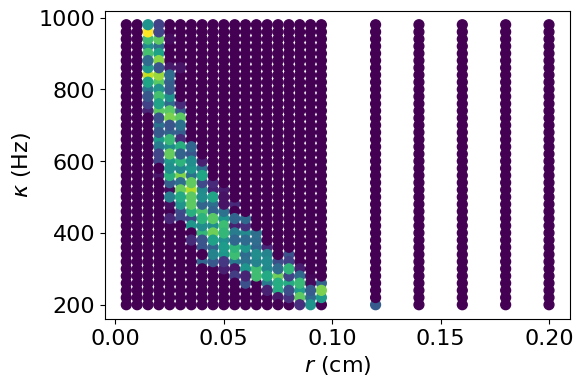

In [44]:
x_values,y_values,c_values=dh[['r','kappa','log_likelihood']].values.T
# #switch to seconds from Hertz on yaxis
# y_values=1/y_values
x_values.shape,y_values.shape,c_values.shape
#basic scatter plot in r,kappa
# vmin = np.min(c_values)
vmin=0
vmax = np.max(c_values)
fig,ax=plt.subplots(figsize=figsize)
ax.scatter(x_values,y_values,s=50,c=c_values,vmin=vmin,vmax=vmax,cmap='viridis')
#format_plot
format_plot(ax=ax,xlabel=r'$r$ (cm)',ylabel=r'$\kappa$ (Hz)',fontsize=fontsize)
plt.show()

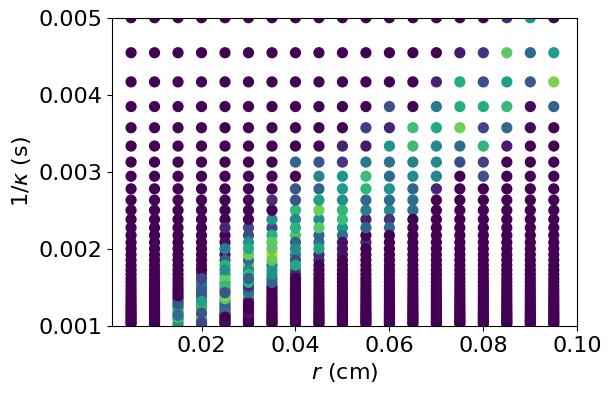

In [45]:
fig,ax=plt.subplots(figsize=figsize)
ax.scatter(x_values,1/y_values,s=50,c=c_values,vmin=vmin,vmax=vmax,cmap='viridis')
#format_plot
format_plot(ax=ax,xlabel=r'$r$ (cm)',ylabel=r'$1/\kappa$ (s)',fontsize=fontsize)#,use_loglog=True)
ax.set_xlim([0.001,0.1])
ax.set_ylim([0.001,0.005])
plt.show()

In [46]:
fontsize=14
ylabel=r'$1/\kappa$ (ms)'
xlabel=r'$r^2$ (cm$^2$)'
# cbar_label='Log-likelihood of linear to $W_{-2}$ of Fenton-Karma'
cbar_label='Log-Likelihood'
fraction=0.07
shrink=0.85
aspect=35
# orientation='horizontal'
orientation='vertical'
extend='max'

In [47]:
# x_values,y_values,c_values=dh[['r','kappa','log_likelihood']].values.T
# #switch to seconds from Hertz on yaxis
# y_values=1/y_values
# #square the xaxis 
# x_values**=2
# x_values.shape,y_values.shape,c_values.shape

x,y,z = meshgrid_heatmap_from_scattergrid(x_values,y_values,c_values)
np.min(z),np.mean(z),np.max(z)

(-2061.126135954136, -194.93327056505842, 18.63310679757182)

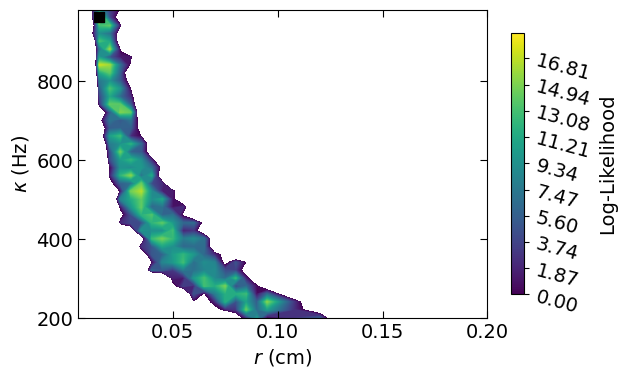

In [48]:
#DONE: plot level sets of likelihood
fig,ax=plt.subplots(figsize=figsize)
cmap='viridis'


# levels = np.array([-1000,-500,-100,0,5,10,15,20])+1000.1
# norm=colors.LogNorm(vmin=0.1,vmax=vmax+1000+0.1)
# cs = ax.contourf(x, y, z+1000.1, levels=levels, cmap=cmap,norm=norm)
# vmin=np.min(c_values)
# vmax=np.max(c_values)
levels = np.linspace(vmin, vmax, 400)
# ax.scatter(x_values,y_values,s=50,c=c_values,vmin=vmin,vmax=vmax,cmap='viridis')
cs = ax.contourf(x, y, z, levels=levels, cmap=cmap)

#TODO: modify the top color to orange

# fig.colorbar(cs, ax=ax, format="%.2f")

#format_plot
format_plot(ax=ax,xlabel=r'$r$ (cm)',ylabel=r'$\kappa$ (Hz)',fontsize=fontsize)
# format_plot(ax=ax,ylabel=r'$r^2$ (cm$^2$)',xlabel=r'$1/\kappa$ (s)',fontsize=fontsize)
# ax.set_xscale('log')
# ax.set_yscale('log')

# #TODO: plot the MLE fit as a big black dot
# x_best = r_best**2
# y_best = 1/kappa_best
# ax.scatter([x_best],[y_best],c='k',s=10,alpha=1,marker='o')
ax.tick_params(bottom=True, left=True, top=True, right=True,direction='in',which='both',length=5)
# ax.tick_params(bottom=True, left=True, top=True, right=True,direction='in',which='major',length=8)
#TODO: format the contour plot to be black-white or grayscale with labels annotating each contour trace. 

#add formated colorbar
cax, kw = mpl.colorbar.make_axes_gridspec(ax, orientation=orientation,#pad=0.1,
                                       fraction=fraction, shrink=shrink)#, cmap=cmap)#aspect=aspect)
cbar=fig.colorbar(cs, cax=cax, orientation=orientation, extend=extend)#, cmap=cmap)#, fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(label=cbar_label,size=fontsize)
# cbar.ax.set_yticks(rotation=30)
# cbar.ax.set_yticks(rotation=45, ha='right')
for label in cbar.ax.get_yticklabels():
    label.set_rotation(-15)

#format plot
# # ax.set_title(title,fontsize=fontsize+2)
# format_plot(ax=ax,xlabel=xlabel,ylabel=ylabel,
#     fontsize=fontsize)#,**kwargs)
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])


#plot the MLE fit as a big black dot
x_best = r_best#**2
y_best = kappa_best
ax.scatter([x_best],[y_best],c='k',s=50,alpha=1.,marker='s',zorder=100)


plt.show()

In [49]:
x_values,y_values,c_values=dh[['x','kappa','log_likelihood']].values.T
# x_values,y_values,c_values=dh[['r','kappa','log_likelihood']].values.T
#switch to ms from Hertz on yaxis
tscale=1e3
y_values=1/y_values
y_values*=tscale
#square the xaxis 
x_values**=2
x_values.shape,y_values.shape,c_values.shape

x,y,z = meshgrid_heatmap_from_scattergrid(x_values,y_values,c_values)
# x,y,z = meshgrid_heatmap_from_scattergrid(y_values,x_values,c_values)
np.min(z),np.mean(z),np.max(z)

(-2061.126135954136, -194.93327056505842, 18.63310679757182)

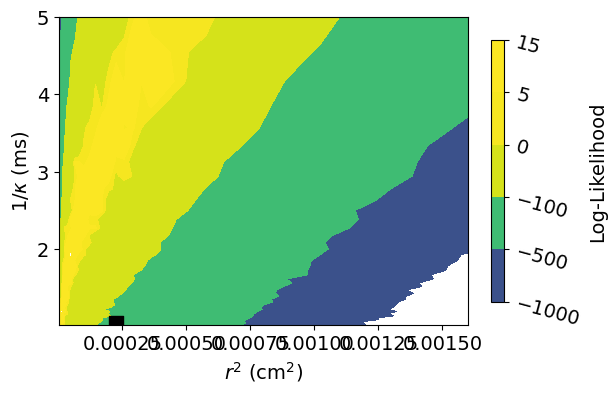

In [50]:
#DONE: plot level sets of likelihood
fig,ax=plt.subplots(figsize=figsize)


# levels = np.array([-1000,-500,-100,0,5,10,15,20])+1000.1
# norm=colors.LogNorm(vmin=0.1,vmax=vmax+1000+0.1)
# cs = ax.contourf(x, y, z+1000.1, levels=levels, cmap=cmap,norm=norm)

# levels = np.linspace(vmin, vmax, 6)
# levels = np.array([-1000,-500,-100,0,5,10,15,20])
# levels = np.array([-1000,-500,-100,0,5,10])#,15,20])
levels = np.array([-1000,-500,-100,0,5,15])#,15,20])
# ax.scatter(x_values,y_values,s=50,c=c_values,vmin=vmin,vmax=vmax,cmap='viridis')
cs = ax.contourf(x, y, z, levels=levels, cmap=cmap)

#TODO: modify the top color to orange

# fig.colorbar(cs, ax=ax, format="%.2f")

#format_plot
# format_plot(ax=ax,ylabel=r'$r$ (cm)',xlabel=r'$1/\kappa$ (s)',fontsize=fontsize)
# format_plot(ax=ax,ylabel=r'$r^2$ (cm$^2$)',xlabel=r'$1/\kappa$ (s)',fontsize=fontsize)
format_plot(ax=ax,ylabel=r'$r^2/L^2$ (cm$^2$)',xlabel=r'$1/\kappa$ (s)',fontsize=fontsize)
# ax.set_xscale('log')
# ax.set_yscale('log')

#TODO: plot the MLE fit as a big black dot
x_best = r_best**2
y_best = 1/kappa_best*tscale
ax.scatter([x_best],[y_best],c='k',s=100,alpha=1,marker='s')

#TODO: format the contour plot to be black-white or grayscale with labels annotating each contour trace. 

#add formated colorbar
cax, kw = mpl.colorbar.make_axes_gridspec(ax, orientation=orientation,#pad=0.1,
                                       fraction=fraction, shrink=shrink)#, cmap=cmap)#aspect=aspect)
cbar=fig.colorbar(cs, cax=cax, orientation=orientation, extend=extend)#, cmap=cmap)#, fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(label=cbar_label,size=fontsize)
# cbar.ax.set_yticks(rotation=30)
# cbar.ax.set_yticks(rotation=45, ha='right')
for label in cbar.ax.get_yticklabels():
    label.set_rotation(-15)

#format plot
# ax.set_title(title,fontsize=fontsize+2)
format_plot(ax=ax,xlabel=xlabel,ylabel=ylabel,
    fontsize=fontsize)#,**kwargs)
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])


plt.show()

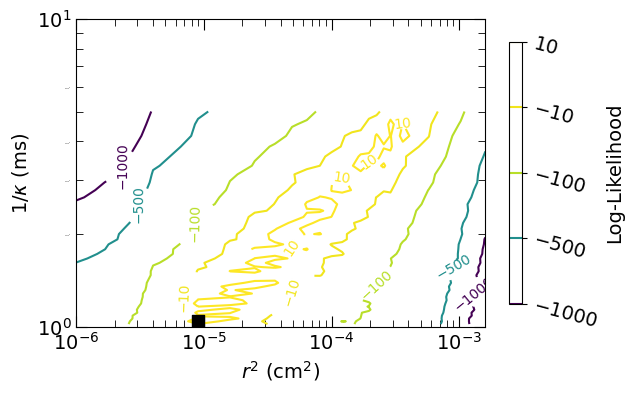

In [51]:
#heretim
#DONE: plot level sets of likelihood
#TODO: plot old timey annotated contour plot
fig,ax=plt.subplots(figsize=figsize)


# levels = np.array([-1000,-500,-100,0,5,10,15,20])+1000.1
# norm=colors.LogNorm(vmin=0.1,vmax=vmax+1000+0.1)
# cs = ax.contourf(x, y, z+1000.1, levels=levels, cmap=cmap,norm=norm)

# levels = np.linspace(vmin, vmax, 6)
# levels = np.array([-1000,-500,-100,0,5,10,15,20])
# levels = np.array([-1000,-500,-100,0,5,10])#,15,20])
# levels = np.array([-1000,-500,-100,0,10])#20])#,15,20])
levels = np.array([-1000,-500,-100,-10,10])#20])#,15,20])
# ax.scatter(x_values,y_values,s=50,c=c_values,vmin=vmin,vmax=vmax,cmap='viridis')
# cs = ax.contourf(x, y, z, levels=levels, cmap=cmap)
cs = ax.contour(x, y, z, levels=levels, cmap=cmap)
ax.clabel(cs, inline=True, fontsize=10)

# #TODO: format the contour plot to be black-white or grayscale with labels annotating each contour trace. 
# CS = ax.contour(X, Y, Z)
# ax.clabel(CS, inline=True, fontsize=10)
# ax.set_title('Simplest default with labels')



#TODO: modify the top color to orange

# fig.colorbar(cs, ax=ax, format="%.2f")

# #format_plot
# # format_plot(ax=ax,ylabel=r'$r$ (cm)',xlabel=r'$1/\kappa$ (s)',fontsize=fontsize)
# format_plot(ax=ax,ylabel=r'$r^2$ (cm$^2$)',xlabel=r'$1/\kappa$ (s)',fontsize=fontsize)
# # ax.set_xscale('log')
# # ax.set_yscale('log')

#add formated colorbar
cax, kw = mpl.colorbar.make_axes_gridspec(ax, orientation=orientation,#pad=0.1,
                                       fraction=fraction, shrink=shrink)#, cmap=cmap)#aspect=aspect)
cbar=fig.colorbar(cs, cax=cax, orientation=orientation, extend=extend)#, cmap=cmap)#, fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(label=cbar_label,size=fontsize)
# cbar.ax.set_yticks(rotation=30)
# cbar.ax.set_yticks(rotation=45, ha='right')
for label in cbar.ax.get_yticklabels():
    label.set_rotation(-15)

#plot the MLE fit as a big black dot
x_best = r_best**2
x_best /= L**2
y_best = 1/kappa_best*tscale
ax.scatter([x_best],[y_best],c='k',s=70,alpha=1,marker='s',zorder=100)

ax.tick_params(bottom=True, left=True, top=True, right=True,direction='in',which='both',length=5)
ax.tick_params(bottom=True, left=True, top=True, right=True,direction='in',which='major',length=8)
    
# fig, ax = plt.subplots()
# CS = ax.contour(X, Y, Z, 6, colors='k')  # Negative contours default to dashed.
# ax.clabel(CS, fontsize=9, inline=True)
# ax.set_title('Single color - negative contours dashed')
    
# ax.set_ylim([0.1,11])
    
#format plot
# ax.set_title(title,fontsize=fontsize+2)
# format_plot(ax=ax,xlabel=xlabel,ylabel=ylabel,
#     fontsize=fontsize)#,**kwargs)
format_plot(ax=ax,xlabel=xlabel,ylabel=ylabel,
    fontsize=fontsize,use_loglog=True)
# set the limits of the plot to the limits of the data
# ax.axis([x.min(), x.max(), y.min(), y.max()])
ax.axis([x.min(), x.max(), 1,10])
# ax.axis([x.min(), x.max(), 9e-4,1.1e-2])
# ax.axis([x.min(), x.max(), 9e-4,6e-3])


plt.show()

In [52]:
#set negative lines to be solid instead of dotted
plt.rcParams['contour.negative_linestyle'] = 'solid'


In [110]:
import matplotlib.ticker as mticker
import math

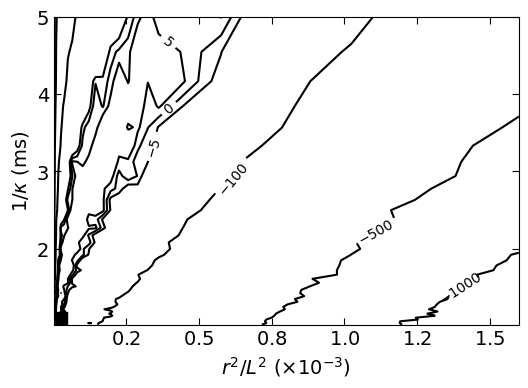

In [109]:
#heretim
#DONE: plot level sets of likelihood
#TODO: plot old timey annotated contour plot
fig,ax=plt.subplots(figsize=figsize)
Lscale=1/L**2
#TODO: add manual_locations
manual_locations = [
    (0.035*Lscale,0.0015*tscale),(0.027*Lscale,0.0025*tscale),(0.015*Lscale, 0.003*tscale),(0.009*Lscale,0.0033*tscale),(0.010*Lscale,0.0038*tscale), (0.01*Lscale,0.0047*tscale)]
#     (0.035,0.0015*tscale),(0.027,0.0025*tscale),(0.015, 0.003*tscale),(0.009,0.0033*tscale),(0.010,0.0038*tscale), (0.01,0.0047*tscale)]
#     (0.035,0.0015),(0.027,0.0025),(0.015, 0.003),(0.009,0.0033),(0.010,0.0038), (0.01,0.0047)]

levels = np.array([-1000,-500,-100,-5,0,5])
cs = ax.contour(x, y, z, levels=levels, colors='k')
ax.clabel(cs, inline=True, fontsize=10, manual=manual_locations)
# ax.clabel(cs, inline=True, fontsize=10)

#plot the MLE fit as a big black diamond
x_best = r_best**2
x_best*=Lscale
y_best = 1/kappa_best*tscale
ax.scatter([x_best],[y_best],c='k',s=270,alpha=1,marker='s',zorder=100)
    
    
#format plot
format_plot(ax=ax,
            xlabel=r'$r^2/L^2$ $(\times10^{-3})$',#xlabel,
            ylabel=ylabel,
    fontsize=fontsize,use_loglog=False)
#     fontsize=fontsize,use_loglog=True)
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
# ax.axis([x.min(), x.max(), 9e-4,1.1e-2])
# ax.axis([x.min(), x.max(), 9e-4,6e-3])
# # ax.set_xscale('log')
# # ax.set_yscale('log')
# ticks=np.arange(1,17,1)
# tick_labels=['' for x in ticks]
# tick_labels[0]=f"{ticks[0]}"+r"$\cdot 10^{-4}$"
# tick_labels[4]=f"{ticks[4]}"+r"$\cdot 10^{-4}$"
# tick_labels[8]=f"{ticks[8]}"+r"$\cdot 10^{-4}$"
# tick_labels[12]=f"{ticks[12]}"+r"$\cdot 10^{-4}$"
# # tick_labels[16]=f"{ticks[16]}"+r"$\cdot 10^{-4}$"
# ticks=np.arange(1,17,2)
# tick_labels=['' for x in ticks]
# tick_labels[0]=f"{ticks[0]}"+r"$\cdot 10^{-4}$"
# tick_labels[2]=f"{ticks[2]}"+r"$\cdot 10^{-4}$"
# tick_labels[4]=f"{ticks[4]}"+r"$\cdot 10^{-4}$"
# tick_labels[6]=f"{ticks[6]}"+r"$\cdot 10^{-4}$"
# # tick_labels[16]=f"{ticks[16]}"+r"$\cdot 10^{-4}$"

# ticks=1e-4*ticks
# ax.set_xticks(ticks)
# ax.set_xticklabels(tick_labels)

# fmt = mticker.FuncFormatter(lambda v, _: ("$%.1f\cdot 10^{-3}$" % (1e3*v)))
fmt = mticker.FuncFormatter(lambda v, _: ("$%.1f$" % (1e3*v)))
ax.xaxis.set_major_formatter(fmt)
ax.xaxis.major.formatter._useMathText = True


ax.tick_params(bottom=True, left=True, top=True, right=True,direction='in',which='both',length=5)
# ax.tick_params(bottom=True, left=True, top=True, right=True,direction='in',which='major',length=8)
plt.show()

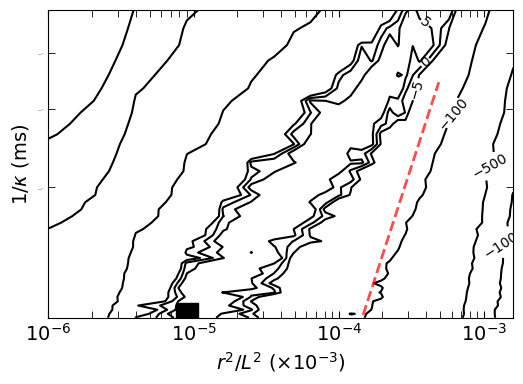

In [172]:
amax = alinear_best+2*D_best
fig,ax=plt.subplots(figsize=figsize)
Lscale=1/L**2
#add manual_locations
manual_locations = [
    (0.035*Lscale,0.0015*tscale),(0.027*Lscale,0.0025*tscale),(0.015*Lscale, 0.003*tscale),(0.009*Lscale,0.0033*tscale),(0.010*Lscale,0.0038*tscale), (0.01*Lscale,0.0047*tscale)]
levels = np.array([-1000,-500,-100,-5,0,5])
cs = ax.contour(x, y, z, levels=levels, colors='k')
ax.clabel(cs, inline=True, fontsize=10, manual=manual_locations)


#plot the MLE fit as a big black diamond
x_best = r_best**2
x_best*=Lscale
y_best = 1/kappa_best*tscale
ax.scatter([x_best],[y_best],c='k',s=270,alpha=1,marker='s',zorder=100)



# #plot locus of kappa*r^2 of constant amax
# kappa_values=np.arange(1,1e3,10)
# bmax=0.5*amax
# bmax=alinear_best#/np.pi #results from variational analysis of reaction range/rate with linear particle model
bmax=2*amax #results from variational analysis of reaction range/rate with linear particle model
# bmax=amax  #aligns well at high likelihood
# bmax=4*amax  #aligns well at low likelihood
# x_values = bmax*Lscale/kappa_values
# y_values = 1/kappa_values
x_values = np.arange(1e-5,0.5,0.01)
# x_values = np.arange(0.01,2,0.01)
x_values*=1e-3
y_values = (x_values/Lscale)/bmax
# y_values = ((x_values/Lscale)/bmax)**0.85
y_values*=1e3 #ms per seconds
# y_values*=1e1
# y_values = 1e2*x_values**0.33
# y_values = 3.5e2*x_values**0.5

# x_values/=np.pi*2
# y_values*=np.pi

plt.plot(x_values,y_values,'r--',lw=2,alpha=0.7,zorder=101)

#format plot
format_plot(ax=ax,
            xlabel=r'$r^2/L^2$ $(\times10^{-3})$',#xlabel,
            ylabel=ylabel,
    fontsize=fontsize,use_loglog=False)
fmt = mticker.FuncFormatter(lambda v, _: ("$%.1f$" % (1e3*v)))
ax.xaxis.set_major_formatter(fmt)
ax.xaxis.major.formatter._useMathText = True
ax.tick_params(bottom=True, left=True, top=True, right=True,direction='in',which='both',length=5)
plt.xscale('log')
plt.yscale('log')

plt.show()

In [55]:
print(f"using our prior parameter setting: {alinear_best=}, {D_best=}, {L_best=}, {int(neighbor_best)=}.")
print(f"the MLE fit is given by {r_best=}, {kappa_best=}")

using our prior parameter setting: alinear_best=1.68, D_best=0.05, L_best=5.0, int(neighbor_best)=0.
the MLE fit is given by r_best=0.015, kappa_best=960.0


In [498]:
#DONT: streamplot in r,kappa
#DONE: basic scatter plot in r,kappa
#DONT: interpolated heat map plot in r,kappa
#DONT: sns heat map in r,kappa
#DONT: streamplot in r,kappa

In [499]:
# #TODO: plot level sets of likelihood
# fig, axs = plt.subplots(1,2)
# x = np.linspace(0, 1, 100)
# X, Y = np.meshgrid(x, x)
# Z = np.sin(X)*np.sin(Y)
# zdata = np.sin(8*X)*np.sin(8*Y)

# # levels = np.linspace(-1, 1, 40)
# levels = np.linspace(-1, 1, 10)
# cs = axs[0].contourf(X, Y, zdata, levels=levels)
# fig.colorbar(cs, ax=axs[0], format="%.2f")

# cs = axs[1].contourf(X, Y, zdata, levels=[-1,0,1])
# fig.colorbar(cs, ax=axs[1])

# plt.show()

# visualize the singular learning theory

In [455]:
run_num=29 #L=10
run_num=26
# parquet_dir_defects_fk=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_fk.parquet'
# parquet_dir_defects_lr=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_lr.parquet'
# input_folder=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'
parquet_dir_defects_fk=f'/Users/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_fk.parquet'
# parquet_dir_defects_lr=f'/Users/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_lr.parquet'

#heretim
run_num=29 #L=10
run_num=28
parquet_dir_defects_lr=f'/Users/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_lr.parquet'
input_folder=f'/Users/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'


#load data
df_defects_fk=pd.read_parquet(parquet_dir_defects_fk)
df_defects_lr=pd.read_parquet(parquet_dir_defects_lr)
#compute order parameter for each member a=amax-2*D
#add columns for amax
df_defects_fk['amax'] = np.around(df_defects_fk['varkappa'] + 2.*df_defects_fk['D'],num_digits_round_amax)
df_defects_lr['amax'] = np.around(df_defects_lr['varkappa'] + 2.*df_defects_lr['D'],num_digits_round_amax)
L_fk = df_defects_fk['L'].values[0]
L_lr = df_defects_lr['L'].values[0]
print(f"{L_fk=}, {L_lr=}")
#heretim
rmax=0.02*50
remove_no_diffusion=True
remove_ranges_larger_than=True
if remove_no_diffusion:
    df_defects_fk = df_defects_fk[df_defects_fk['D']>Dinf].copy()
    df_defects_lr = df_defects_lr[df_defects_lr['D']>Dinf].copy()
if remove_ranges_larger_than:
    df_defects_fk = df_defects_fk[df_defects_fk['r']<=rmax].copy()
    df_defects_lr = df_defects_lr[df_defects_lr['r']<=rmax].copy()

    
minl=0
minl=10
# minl=1
tscale_kappa=1e3 #ms per s
#compute the xyzc values of this slt
df = df_defects_fk
df['x'] = df['r']/df['L']
# df['y'] = 1/df['kappa']*tscale_kappa
df['y'] = df['kappa']#*tscale_kappa
df['z'] = df['varkappa']/(df['L']**2)
df['c'] = df['log_likelihood']
# df['c'] = np.log(df['log_likelihood'])
# df['s'] = df['log_likelihood']*5
df['s'] = 50#/df['log_likelihood']
boo_fk = df['c'] > minl

df = df_defects_lr
df['x'] = df['r']/df['L']
# df['y'] = 1/df['kappa']*tscale_kappa
df['y'] = df['kappa']#*tscale_kappa

df['z'] = df['varkappa']#/(df['L']**2)
df['c'] = df['log_likelihood']
# df['c'] = np.log(df['log_likelihood'])
# df['s'] = df['log_likelihood']*1
df['s'] = 50#/df['log_likelihood']
boo_lr = df['c'] > minl

#drop any rows that do not have the prior orthogonal parameter settings for the mle fit
df=df_defects_fk
boo=df['log_likelihood']==df['log_likelihood'].max()
x_best_fk = df[boo]['x'].values[0]
y_best_fk = df[boo]['y'].values[0]
z_best_fk = df[boo]['z'].values[0]
c_best_fk = df[boo]['c'].values[0]
s_best_fk = df[boo]['s'].values[0]
#compute the first integral
amax_fk = df[boo]['amax'].values[0]

df=df_defects_lr
boo=df['log_likelihood']==df['log_likelihood'].max()
x_best_lr = df[boo]['x'].values[0]
y_best_lr = df[boo]['y'].values[0]
z_best_lr = df[boo]['z'].values[0]
c_best_lr = df[boo]['c'].values[0]
s_best_lr = df[boo]['s'].values[0]
#compute the first integral
amax_lr = df[boo]['amax'].values[0]
amax_lr



#filter by amax as the first integral
df_defects_fk = df_defects_fk[boo_fk&(df_defects_fk['amax']==amax_fk)].copy()
df_defects_lr = df_defects_lr[boo_lr&(df_defects_lr['amax']==amax_lr)].copy()

L_fk=5.0, L_lr=5.0


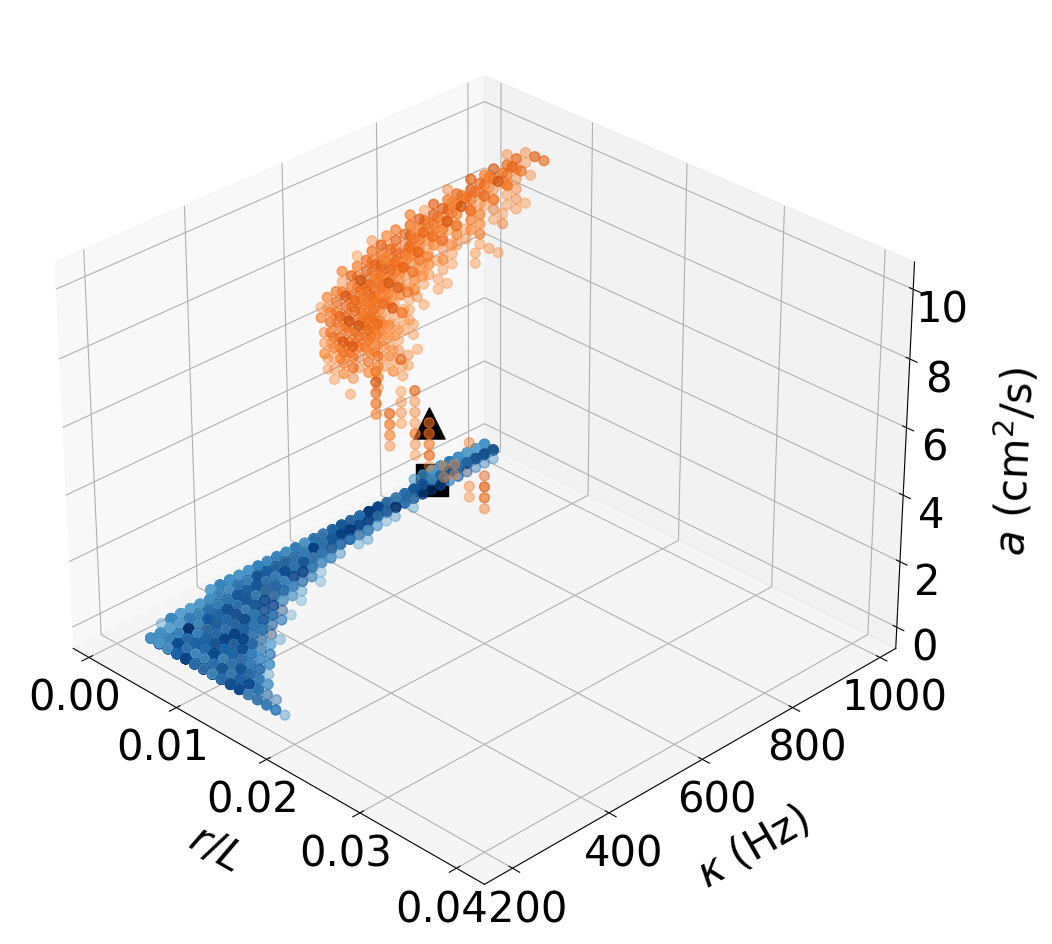

In [460]:
#scatter plot all those who have strictly positive log likelihood in their annihilation fit to the fenton-karma model
# fig,ax=plt.subplots()
vmin=0
vmax=20
# fontsize=14
# fontsize=20
fontsize=30
alpha=0.4
# alpha=0.03
xlabel=f'\n\n'+r'$r/L$'
# ylabel=f'\n'+r'$1/\kappa$ (ms)'
ylabel=f'\n\n'+r'$\kappa$ (Hz)'
# zlabel=f'\n'+r'$a/L^2$ (Hz)'
zlabel=f'\n\n'+r'$a$ (cm$^2$/s)'
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(xs=df_defects_fk['x'],
           ys=df_defects_fk['y'],
           zs=df_defects_fk['z'],
           c=df_defects_fk['c'],
           s=df_defects_fk['s'],
           alpha=alpha,label='Fenton-Karma',cmap='Blues',vmin=vmin,vmax=vmax,zorder=100)
alpha=0.4
# alpha=0.1
ax.scatter(xs=df_defects_lr['x'],
           ys=df_defects_lr['y'],
           zs=df_defects_lr['z'],
           c=df_defects_lr['c'],
           s=df_defects_lr['s'],
           alpha=alpha,label='Luo-Rudy',cmap='Oranges',vmin=vmin,vmax=vmax)

#plot the best fits as (LR) a big triangle and as (FK) a big square 
ax.scatter(xs=[x_best_fk],
           ys=[y_best_fk],
           zs=[z_best_fk],
           c='k',
           s=500,
           marker='s',
           alpha=1.,zorder=10)
ax.scatter(xs=[x_best_lr],
           ys=[y_best_lr],
           zs=[z_best_lr],
           c='k',
           s=500,
           marker='^',
           alpha=1.,zorder=100)

#format_plot
format_plot(ax=ax,xlabel=xlabel,ylabel=ylabel,fontsize=fontsize)
ax.set_zlabel(zlabel=zlabel,fontsize=fontsize)
# ax.set_yticks([0,1,2,3,4,5])
# axx=ax.get_axes()
azm=ax.azim
ele=ax.elev
dst=ax.dist       # ALWAYS GIVES 10
#dst=ax1.axes.dist # ALWAYS GIVES 10
#dst=ax1.dist      # ALWAYS GIVES 10

#set observation angle
azm=-60
azm=-45
ele=30
ele=-45
# ele=-30
ele=30
ax.view_init(elev=ele, azim=azm) #Works!

# AddLegend()
plt.show()

In [303]:
ele

-30

In [209]:
x_best_fk,y_best_fk,z_best_fk

(0.002, 1.1904761904761907, 0.08199999999999999)